In [1]:
# Author : shadril238
!find /content -maxdepth 3 -iname "sympy.py" -o -iname "sympy"

In [ ]:
!pip -q uninstall -y sympy
!pip -q install -U sympy==1.13.1

import sympy
print("sympy version:", sympy.__version__)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.9.0+cu126 requires sympy>=1.13.3, but you have sympy 1.13.1 which is incompatible.
sympy version: 1.13.1


In [ ]:
# Imports and configs

import os, random, math, time, json
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.amp import autocast, GradScaler

from torchvision import datasets

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, balanced_accuracy_score
)

import timm
from timm.data import resolve_data_config, create_transform
from timm.utils import ModelEmaV2

!pip install optuna captum
import optuna
from captum.attr import LayerGradCam, IntegratedGradients

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

seed_everything(42)

@dataclass
class CFG:
    dataset_path: str = "/content/drive/MyDrive/ml-project2/dataset"
    num_workers: int = 2

    train_ratio: float = 0.70
    val_ratio: float = 0.15
    test_ratio: float = 0.15

    batch_size: int = 32
    epochs_quick: int = 6
    epochs_full: int = 14
    patience: int = 5

    lr: float = 3e-4
    lr_head: float = 1e-3
    weight_decay: float = 1e-4
    label_smoothing: float = 0.05

    img_size: int = 224
    img_size_big: int = 384

    mixup: float = 0.2
    cutmix: float = 0.2

    grad_clip: float = 1.0

    n_trials_best_model: int = 12
    n_trials_custom_vit: int = 15

CFG = CFG()

Device: cuda


In [ ]:
# Mounts Google Drive
from google.colab import drive
drive.mount("/content/drive")

assert os.path.exists(CFG.dataset_path), f"Dataset path not found: {CFG.dataset_path}"
print("Dataset path OK:", CFG.dataset_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset path OK: /content/drive/MyDrive/ml-project2/dataset


class  count
0                 natrix-natrix    426
1       lampropeltis-triangulum    418
2                crotalus-atrox    412
3        agkistrodon-piscivorus    410
4           thamnophis-sirtalis    400
5         pantherophis-guttatus    399
6         heterodon-platirhinos    395
7         masticophis-flagellum    393
8               storeria-dekayi    390
9           coluber-constrictor    385
10             nerodia-fasciata    381
11    storeria-occipitomaculata    379
12        rhinocheilus-lecontei    378
13          diadophis-punctatus    376
14           opheodrys-aestivus    376
15       pantherophis-obsoletus    375
16  pantherophis-alleghaniensis    375
17             crotalus-viridis    375
18          crotalus-scutulatus    374
19             haldea-striatula    373
20     lampropeltis-californiae    373
21          pituophis-catenifer    371
22        nerodia-erythrogaster    370
23              nerodia-sipedon    370
24           thamnophis-elegans    370
25       pantherophis-spiloides    368
26        pantherophis-vulpinus    364
27       agkistrodon-contortrix    360
28            nerodia-rhombifer    360
29            crotalus-horridus    359
30          thamnophis-proximus    358
31               crotalus-ruber    351
32         thamnophis-marcianus    349
33             thamnophis-radix    343
34          pantherophis-emoryi    329

Total images: 13185
Num classes: 35


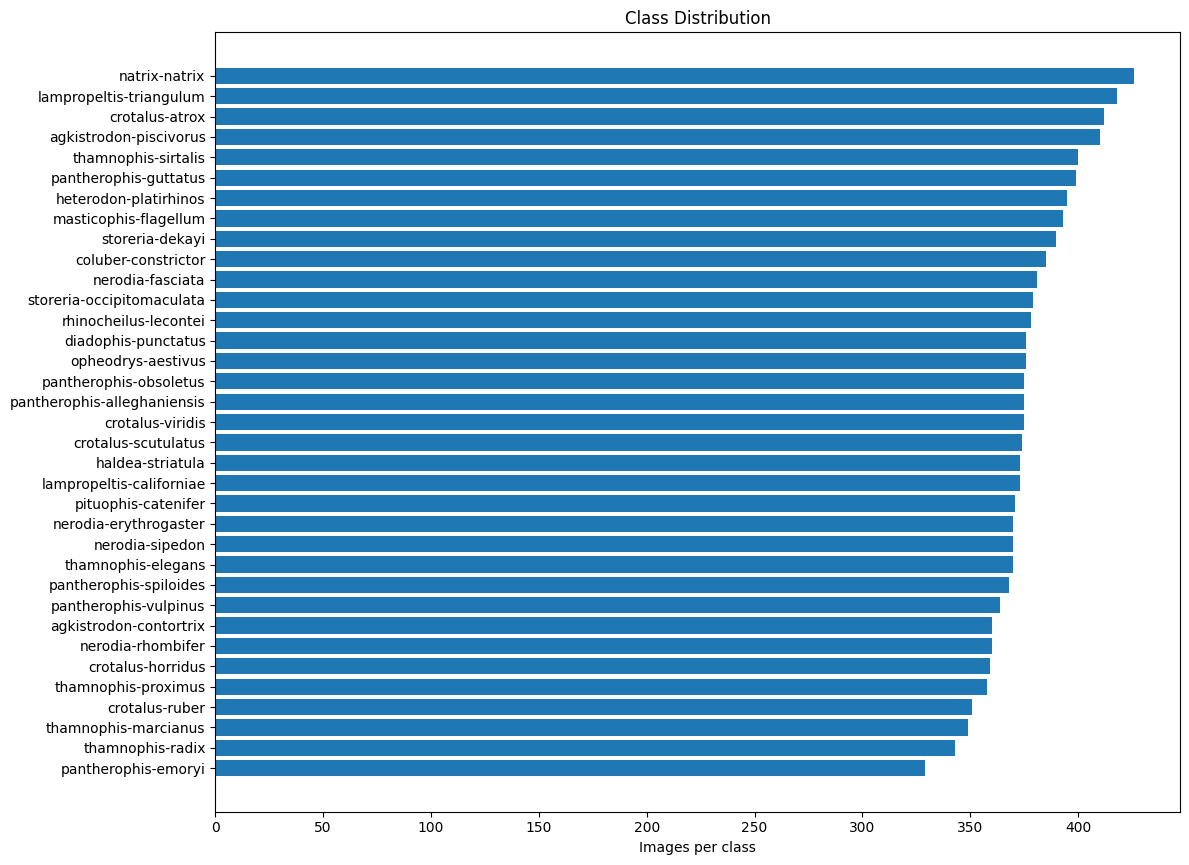

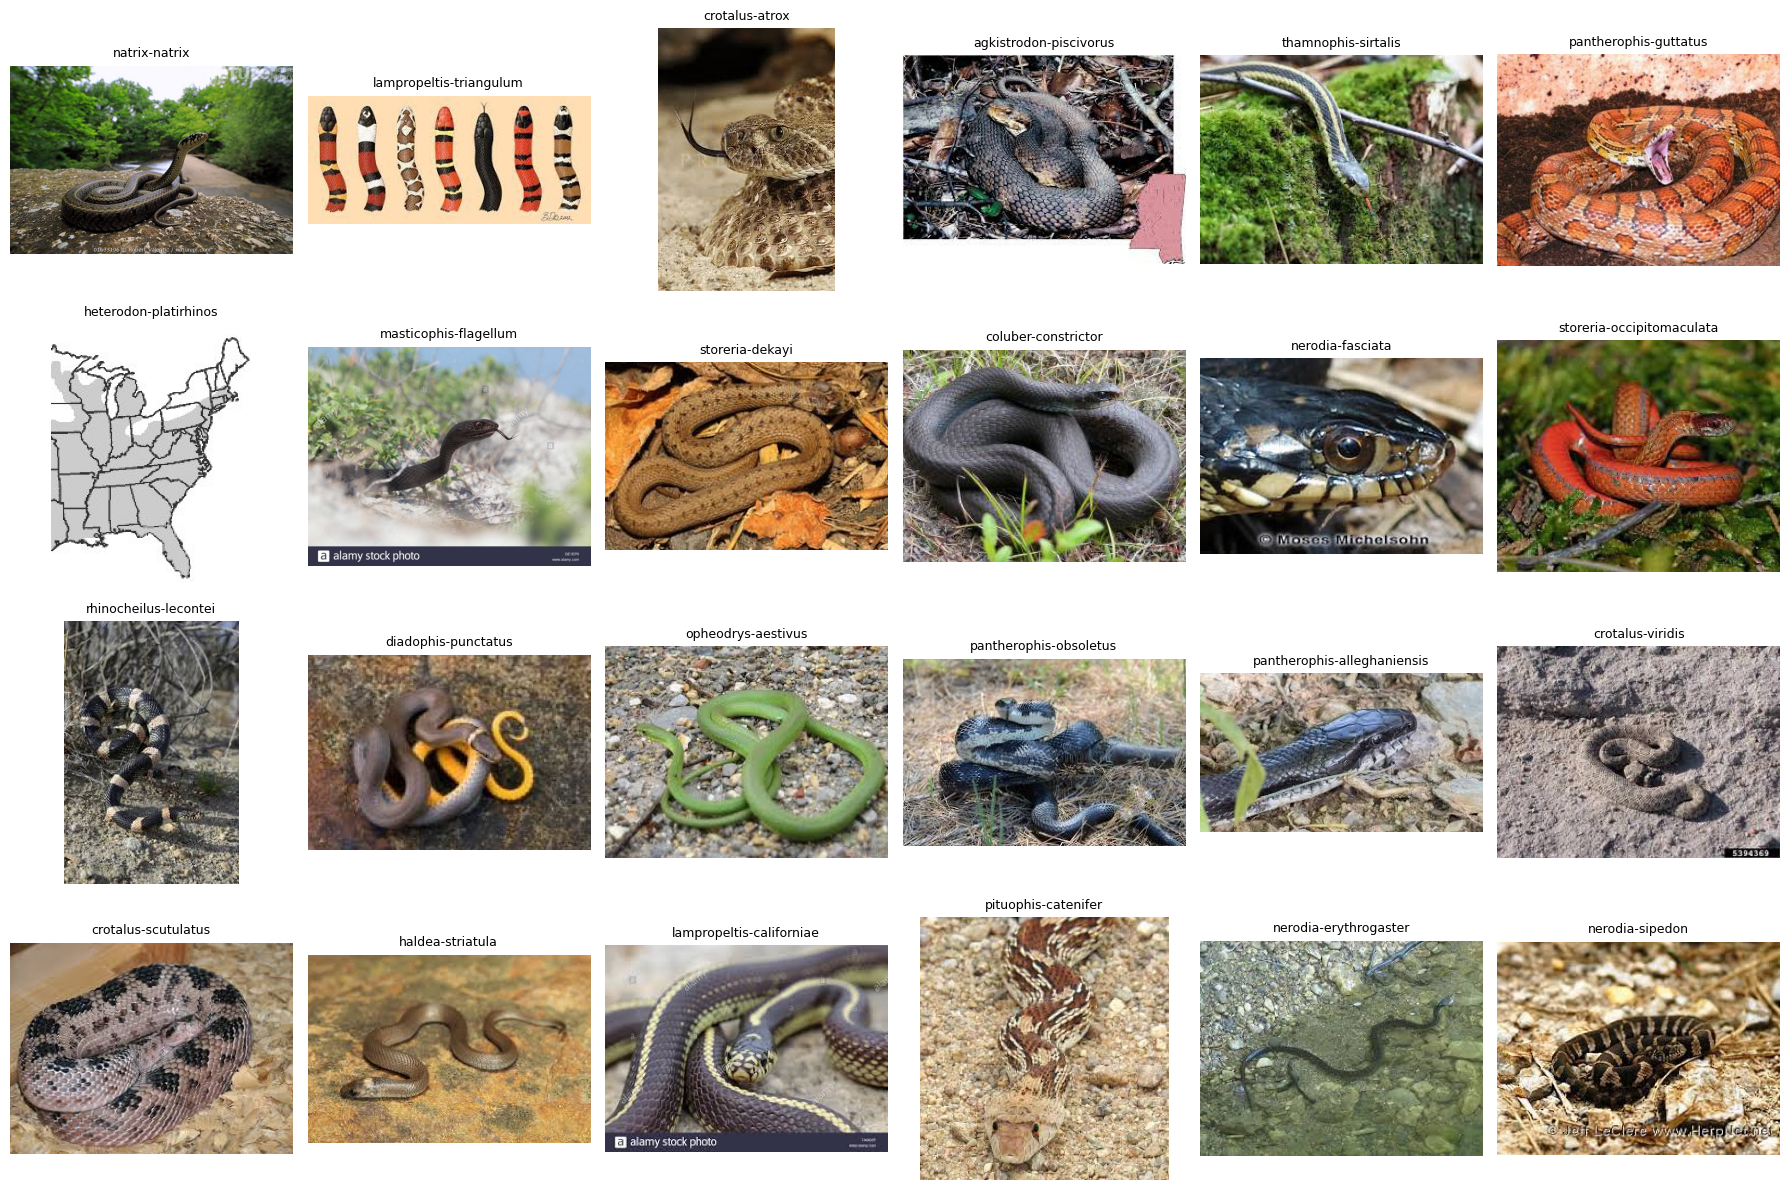

In [ ]:
# Data Analysis

img_exts = (".png", ".jpg", ".jpeg", ".bmp", ".gif", ".webp")

def scan_dataset(root: str) -> pd.DataFrame:
    rows = []
    for cls in sorted(os.listdir(root)):
        cls_dir = os.path.join(root, cls)
        if not os.path.isdir(cls_dir):
            continue
        files = [f for f in os.listdir(cls_dir) if f.lower().endswith(img_exts)]
        rows.append({"class": cls, "count": len(files)})
    return pd.DataFrame(rows).sort_values("count", ascending=False).reset_index(drop=True)

df_stats = scan_dataset(CFG.dataset_path)
display(df_stats)
print("Total images:", int(df_stats["count"].sum()))
print("Num classes:", len(df_stats))

plt.figure(figsize=(12, max(6, len(df_stats)*0.25)))
plt.barh(df_stats["class"], df_stats["count"])
plt.gca().invert_yaxis()
plt.title("Class Distribution")
plt.xlabel("Images per class")
plt.tight_layout()
plt.show()

def show_samples_per_class(root: str, df: pd.DataFrame, k: int = 24, cols: int = 6):
    k = min(k, len(df))
    rows = math.ceil(k / cols)
    plt.figure(figsize=(cols*3, rows*3))
    shown = 0
    for i in range(k):
        cls = df.loc[i, "class"]
        cls_dir = os.path.join(root, cls)
        files = [f for f in os.listdir(cls_dir) if f.lower().endswith(img_exts)]
        if not files:
            continue
        p = os.path.join(cls_dir, random.choice(files))
        img = cv2.imread(p)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        shown += 1
        plt.subplot(rows, cols, shown)
        plt.imshow(img)
        plt.title(cls, fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples_per_class(CFG.dataset_path, df_stats, k=24, cols=6)


Bad images found: 0
Width min, median, max: 1 275 5050
Height min, median, max: 1 194 4032


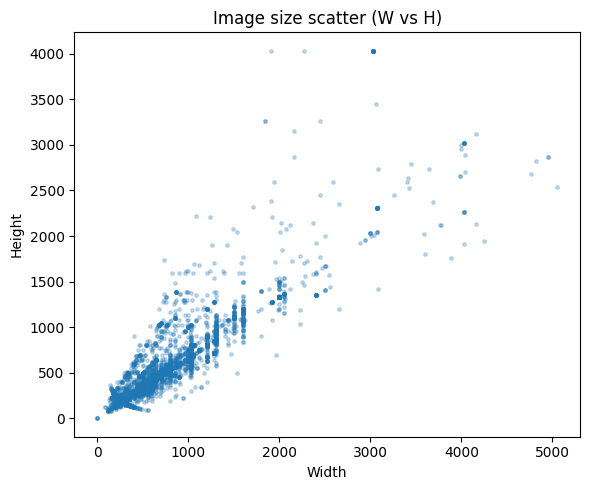

In [ ]:
# Detect corrupted images and size outliers.

def check_images(root: str, max_per_class: int = 3000) -> pd.DataFrame:
    bad = []
    sizes = []

    for cls in sorted(os.listdir(root)):
        cls_dir = os.path.join(root, cls)
        if not os.path.isdir(cls_dir):
            continue
        files = [f for f in os.listdir(cls_dir) if f.lower().endswith(img_exts)]
        files = files[:max_per_class]
        for f in files:
            p = os.path.join(cls_dir, f)
            try:
                img = Image.open(p).convert("RGB")
                w, h = img.size
                sizes.append((w, h))
            except Exception as e:
                bad.append({"class": cls, "file": f, "error": str(e)})

    df_bad = pd.DataFrame(bad)
    print("Bad images found:", len(df_bad))

    if len(sizes) > 0:
        sizes = np.array(sizes)
        print("Width min, median, max:", int(sizes[:,0].min()), int(np.median(sizes[:,0])), int(sizes[:,0].max()))
        print("Height min, median, max:", int(sizes[:,1].min()), int(np.median(sizes[:,1])), int(sizes[:,1].max()))

        plt.figure(figsize=(6,5))
        plt.scatter(sizes[:,0], sizes[:,1], s=6, alpha=0.25)
        plt.title("Image size scatter (W vs H)")
        plt.xlabel("Width")
        plt.ylabel("Height")
        plt.tight_layout()
        plt.show()

    return df_bad

df_bad = check_images(CFG.dataset_path)
if len(df_bad) > 0:
    display(df_bad.head(30))


Split sizes: 9229 1978 1978
Num classes: 35


class  train  val  test
14                natrix-natrix    298   64    64
12      lampropeltis-triangulum    293   62    63
3                crotalus-atrox    288   62    62
1        agkistrodon-piscivorus    287   62    61
34          thamnophis-sirtalis    280   60    60
22        pantherophis-guttatus    279   60    60
10        heterodon-platirhinos    276   60    59
13        masticophis-flagellum    275   59    59
28              storeria-dekayi    273   59    58
2           coluber-constrictor    269   58    58
16             nerodia-fasciata    267   57    57
27        rhinocheilus-lecontei    265   56    57
29    storeria-occipitomaculata    265   57    57
7              crotalus-viridis    263   56    56
19           opheodrys-aestivus    263   56    57
8           diadophis-punctatus    263   56    57
20  pantherophis-alleghaniensis    263   56    56
23       pantherophis-obsoletus    262   56    57
6           crotalus-scutulatus    262   56    56
9              haldea-striatula    261   56    56

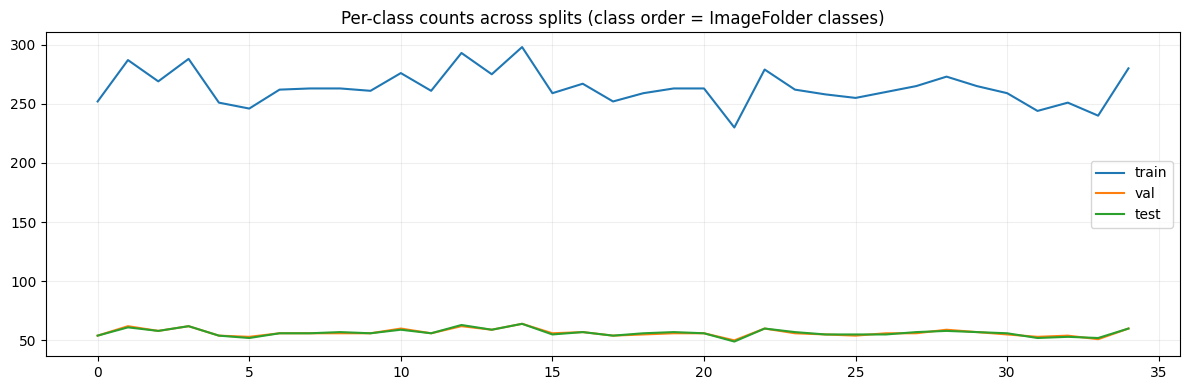

In [ ]:
# Creates stratified train/val/test splits

base_ds = datasets.ImageFolder(CFG.dataset_path)
classes = base_ds.classes
num_classes = len(classes)
targets = np.array([t for _, t in base_ds.samples])
idx_all = np.arange(len(base_ds))

train_idx, tmp_idx = train_test_split(
    idx_all,
    test_size=(1.0 - CFG.train_ratio),
    stratify=targets,
    random_state=42
)

tmp_targets = targets[tmp_idx]
val_rel = CFG.val_ratio / (CFG.val_ratio + CFG.test_ratio)

val_idx, test_idx = train_test_split(
    tmp_idx,
    test_size=(1.0 - val_rel),
    stratify=tmp_targets,
    random_state=42
)

print("Split sizes:", len(train_idx), len(val_idx), len(test_idx))
print("Num classes:", num_classes)

def split_counts(idxs):
    return np.bincount(targets[idxs], minlength=num_classes)

df_split = pd.DataFrame({
    "class": classes,
    "train": split_counts(train_idx),
    "val": split_counts(val_idx),
    "test": split_counts(test_idx),
})
display(df_split.sort_values("train", ascending=False).head(20))

plt.figure(figsize=(12,4))
plt.plot(df_split["train"].values, label="train")
plt.plot(df_split["val"].values, label="val")
plt.plot(df_split["test"].values, label="test")
plt.title("Per-class counts across splits (class order = ImageFolder classes)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


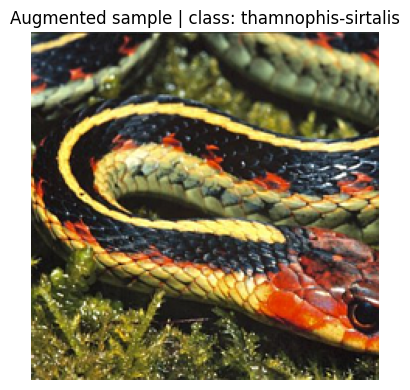

In [ ]:
# Builds model-specific transforms, previews augmentations and normalization.

def build_transforms(model_name: str, img_size: int, is_train: bool):
    model = timm.create_model(model_name, pretrained=True)
    data_cfg = resolve_data_config({}, model=model)
    data_cfg["input_size"] = (3, img_size, img_size)

    if is_train:
        tfm = create_transform(
            input_size=data_cfg["input_size"],
            is_training=True,
            interpolation=data_cfg.get("interpolation", "bicubic"),
            mean=data_cfg.get("mean", (0.485, 0.456, 0.406)),
            std=data_cfg.get("std", (0.229, 0.224, 0.225)),
            crop_pct=data_cfg.get("crop_pct", 0.875),

            auto_augment="rand-m7-mstd0.5-inc1",
            re_prob=0.10,
            re_mode="pixel",
            re_count=1,
        )
    else:
        tfm = create_transform(
            input_size=data_cfg["input_size"],
            is_training=False,
            interpolation=data_cfg.get("interpolation", "bicubic"),
            mean=data_cfg.get("mean", (0.485, 0.456, 0.406)),
            std=data_cfg.get("std", (0.229, 0.224, 0.225)),
            crop_pct=data_cfg.get("crop_pct", 0.875),
        )

    return tfm, data_cfg

def denorm_tensor(x, mean, std):
    mean = torch.tensor(mean)[:, None, None]
    std  = torch.tensor(std)[:, None, None]
    x = x.cpu() * std + mean
    return x.clamp(0, 1)

preview_model = "tf_efficientnetv2_s"
train_tfm, cfg_t = build_transforms(preview_model, CFG.img_size, True)

preview_ds = datasets.ImageFolder(CFG.dataset_path, transform=train_tfm)
x, y = preview_ds[random.randint(0, len(preview_ds)-1)]

plt.figure(figsize=(4,4))
plt.imshow(denorm_tensor(x, cfg_t["mean"], cfg_t["std"]).permute(1,2,0))
plt.title(f"Augmented sample | class: {classes[y]}")
plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
# Creates dataLoaders

def make_loaders(model_name: str, img_size: int, batch_size: int):
    train_tfm, data_cfg = build_transforms(model_name, img_size, True)
    eval_tfm, _ = build_transforms(model_name, img_size, False)

    train_ds = datasets.ImageFolder(CFG.dataset_path, transform=train_tfm)
    val_ds   = datasets.ImageFolder(CFG.dataset_path, transform=eval_tfm)
    test_ds  = datasets.ImageFolder(CFG.dataset_path, transform=eval_tfm)

    train_subset = Subset(train_ds, train_idx)
    val_subset   = Subset(val_ds, val_idx)
    test_subset  = Subset(test_ds, test_idx)

    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True
    )
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True
    )
    test_loader = DataLoader(
        test_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader, data_cfg, train_subset, val_subset, test_subset


In [ ]:
# Defines class-weighting, evaluation metrics, and EMA training loop.

def make_class_weight_tensor():
    class_counts = np.bincount(targets[train_idx], minlength=num_classes).astype(np.float32)
    w = (class_counts.sum() / np.maximum(class_counts, 1.0))
    w = w / w.mean()
    return torch.tensor(w, device=device)

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    all_y, all_p = [], []
    n = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with autocast(device_type="cuda" if device=="cuda" else "cpu"):
            logits = model(x)
            loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)

        all_y.append(y.detach().cpu().numpy())
        all_p.append(preds.detach().cpu().numpy())
        n += x.size(0)

    y_true = np.concatenate(all_y)
    y_pred = np.concatenate(all_p)

    return {
        "loss": total_loss / max(1, n),
        "acc": accuracy_score(y_true, y_pred),
        "bal_acc": balanced_accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
    }, y_true, y_pred

def plot_history(hist, title):
    df = pd.DataFrame(hist)
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(df["train_loss"], label="train_loss")
    plt.plot(df["val_loss"], label="val_loss")
    plt.title(title + " loss")
    plt.legend()
    plt.grid(True, alpha=0.2)

    plt.subplot(1,2,2)
    plt.plot(df["train_acc"], label="train_acc")
    plt.plot(df["val_acc"], label="val_acc")
    plt.title(title + " accuracy")
    plt.legend()
    plt.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    epochs: int,
    lr: float,
    weight_decay: float,
    patience: int,
    model_name: str
):
    model = model.to(device)
    scaler = GradScaler("cuda") if device == "cuda" else GradScaler("cpu")
    ema = ModelEmaV2(model, decay=0.999)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(1, epochs))

    best = -1.0
    best_state = None
    bad = 0
    hist = []

    for ep in range(1, epochs+1):
        model.train()
        tot, cor, tloss = 0, 0, 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)

            with autocast(device_type="cuda" if device=="cuda" else "cpu"):
                logits = model(x)
                loss = criterion(logits, y)

            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.grad_clip)
            scaler.step(opt)
            scaler.update()

            ema.update(model)

            tloss += loss.item() * x.size(0)
            cor += (logits.argmax(1) == y).sum().item()
            tot += x.size(0)

        sch.step()

        val_m, _, _ = evaluate(ema.module, val_loader, criterion)

        tr_acc = cor / max(1, tot)
        tr_loss = tloss / max(1, tot)

        hist.append({
            "epoch": ep,
            "train_loss": tr_loss,
            "train_acc": tr_acc,
            "val_loss": val_m["loss"],
            "val_acc": val_m["acc"],
            "val_f1_macro": val_m["f1_macro"],
            "lr": opt.param_groups[0]["lr"]
        })

        print(f"[{model_name}] ep {ep:02d} tr_acc {tr_acc:.4f} val_acc {val_m['acc']:.4f} val_f1 {val_m['f1_macro']:.4f}")

        if val_m["acc"] > best:
            best = val_m["acc"]
            best_state = {k: v.detach().cpu() for k, v in ema.module.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping")
                break

    if best_state is not None:
        ema.module.load_state_dict(best_state)

    return ema.module, hist


In [ ]:
# Extracts pretrained CNN embeddings for train, val, test splits.

@torch.no_grad()
def extract_embeddings(backbone_name: str, img_size: int, batch_size: int):
    eval_tfm, cfg = build_transforms(backbone_name, img_size, False)
    ds = datasets.ImageFolder(CFG.dataset_path, transform=eval_tfm)

    tr = Subset(ds, train_idx)
    va = Subset(ds, val_idx)
    te = Subset(ds, test_idx)

    tr_loader = DataLoader(tr, batch_size=batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
    va_loader = DataLoader(va, batch_size=batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
    te_loader = DataLoader(te, batch_size=batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)

    feat_model = timm.create_model(backbone_name, pretrained=True, num_classes=0).to(device).eval()
    dim = feat_model.num_features
    print("Backbone:", backbone_name, "| feature_dim:", dim)

    def run(loader):
        feats, labs = [], []
        for x, y in loader:
            x = x.to(device)
            with autocast(device_type="cuda" if device=="cuda" else "cpu"):
                f = feat_model(x)
            feats.append(f.detach().cpu().float().numpy())
            labs.append(y.numpy())
        return np.concatenate(feats), np.concatenate(labs)

    Xtr, ytr = run(tr_loader)
    Xva, yva = run(va_loader)
    Xte, yte = run(te_loader)

    return (Xtr, ytr), (Xva, yva), (Xte, yte), cfg

cnn_backbone = "tf_efficientnetv2_s"
(Xtr_cnn, ytr), (Xva_cnn, yva), (Xte_cnn, yte), cfg_cnn = extract_embeddings(cnn_backbone, CFG.img_size, batch_size=64)

print("CNN embeddings:", Xtr_cnn.shape, Xva_cnn.shape, Xte_cnn.shape)


Backbone: tf_efficientnetv2_s | feature_dim: 1280
CNN embeddings: (9229, 1280) (1978, 1280) (1978, 1280)


In [ ]:
# Extracts ViT embeddings and concatenates with CNN for hybrid features.

vit_backbone = "vit_base_patch16_224"
(Xtr_vit, _), (Xva_vit, _), (Xte_vit, _), cfg_vit = extract_embeddings(vit_backbone, CFG.img_size, batch_size=64)

print("ViT embeddings:", Xtr_vit.shape, Xva_vit.shape, Xte_vit.shape)

Xtr_h = np.concatenate([Xtr_cnn, Xtr_vit], axis=1)
Xva_h = np.concatenate([Xva_cnn, Xva_vit], axis=1)
Xte_h = np.concatenate([Xte_cnn, Xte_vit], axis=1)

print("Hybrid embeddings:", Xtr_h.shape, Xva_h.shape, Xte_h.shape)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Backbone: vit_base_patch16_224 | feature_dim: 768
ViT embeddings: (9229, 768) (1978, 768) (1978, 768)
Hybrid embeddings: (9229, 2048) (1978, 2048) (1978, 2048)


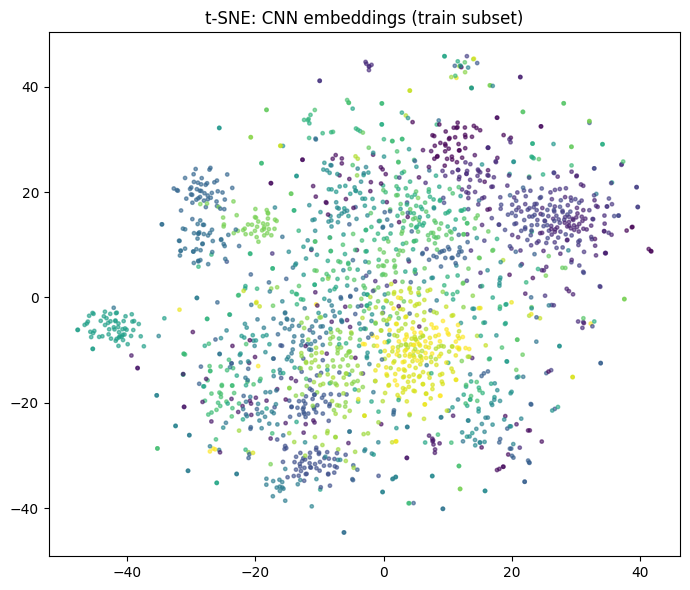

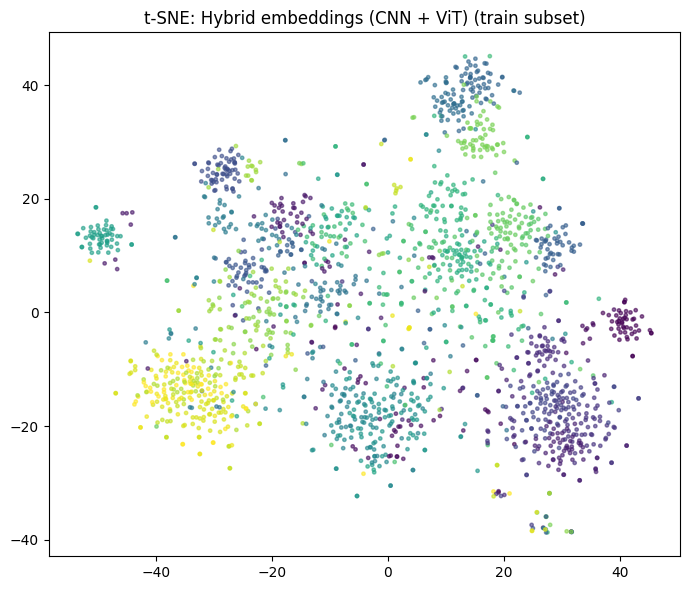

In [ ]:
# Visualizes CNN and hybrid embeddings using t-SNE plots.

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def tsne_plot(X, y, title, max_points=2000):
    n = min(max_points, len(X))
    idx = np.random.choice(len(X), size=n, replace=False)
    Xs = StandardScaler().fit_transform(X[idx])

    tsne = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto", random_state=42)
    Z = tsne.fit_transform(Xs)

    plt.figure(figsize=(7,6))
    plt.scatter(Z[:,0], Z[:,1], c=y[idx], s=6, alpha=0.6)
    plt.title(title)
    plt.tight_layout()
    plt.show()

tsne_plot(Xtr_cnn, ytr, "t-SNE: CNN embeddings (train subset)")
tsne_plot(Xtr_h, ytr, "t-SNE: Hybrid embeddings (CNN + ViT) (train subset)")


[MLP_CNNfeat] ep 01 tr_acc 0.4658 val_acc 0.6466
[MLP_CNNfeat] ep 02 tr_acc 0.6886 val_acc 0.7179
[MLP_CNNfeat] ep 03 tr_acc 0.7892 val_acc 0.7614
[MLP_CNNfeat] ep 04 tr_acc 0.8480 val_acc 0.7867
[MLP_CNNfeat] ep 05 tr_acc 0.8961 val_acc 0.7861
[MLP_CNNfeat] ep 06 tr_acc 0.9189 val_acc 0.7927
[MLP_CNNfeat] ep 07 tr_acc 0.9461 val_acc 0.8099
[MLP_CNNfeat] ep 08 tr_acc 0.9513 val_acc 0.8069
[MLP_CNNfeat] ep 09 tr_acc 0.9606 val_acc 0.8114
[MLP_CNNfeat] ep 10 tr_acc 0.9684 val_acc 0.8185
[MLP_CNNfeat] ep 11 tr_acc 0.9701 val_acc 0.8094
[MLP_CNNfeat] ep 12 tr_acc 0.9709 val_acc 0.8145
[MLP_CNNfeat] ep 13 tr_acc 0.9761 val_acc 0.8064
[MLP_CNNfeat] ep 14 tr_acc 0.9772 val_acc 0.8165
[MLP_CNNfeat] ep 15 tr_acc 0.9789 val_acc 0.8210
[MLP_CNNfeat] ep 16 tr_acc 0.9799 val_acc 0.8190
[MLP_CNNfeat] ep 17 tr_acc 0.9805 val_acc 0.8180
[MLP_CNNfeat] ep 18 tr_acc 0.9805 val_acc 0.8180
[MLP_CNNfeat] ep 19 tr_acc 0.9838 val_acc 0.8175
[MLP_CNNfeat] ep 20 tr_acc 0.9823 val_acc 0.8150
[MLP_CNNfeat] ep 21 

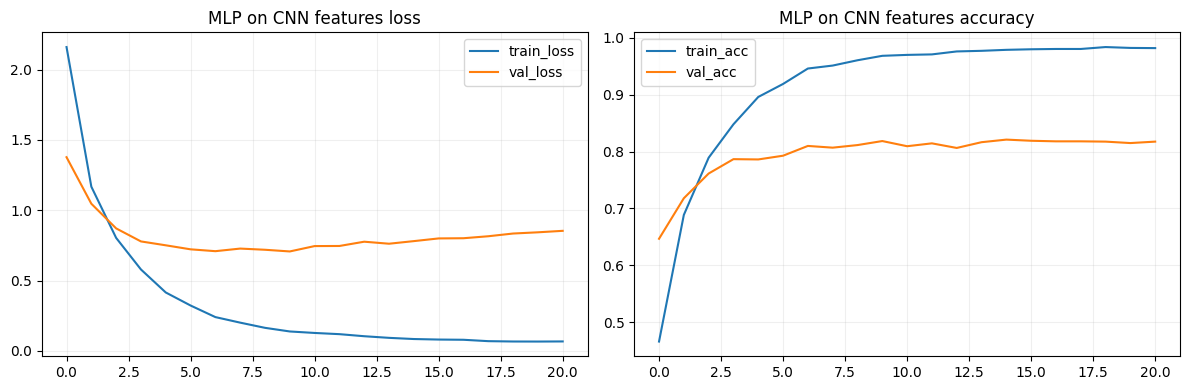

MLP_CNNfeat: {'test_acc': 0.8129423660262892, 'test_f1_macro': 0.8123565829701384}


In [ ]:
# Trains MLP classifier on extracted CNN embeddings.

class MLPClassifier(nn.Module):
    def __init__(self, in_dim: int, num_classes: int, hidden: int = 512, dropout: float = 0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.BatchNorm1d(hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden//2),
            nn.BatchNorm1d(hidden//2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden//2, num_classes),
        )

    def forward(self, x):
        return self.net(x)

class NumpyFeatureDataset(torch.utils.data.Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

def train_mlp_on_features(Xtr, ytr, Xva, yva, Xte, yte, hidden=512, dropout=0.3, lr=1e-3, wd=1e-4, epochs=25, patience=6, name="MLP"):
    tr_ds = NumpyFeatureDataset(Xtr, ytr)
    va_ds = NumpyFeatureDataset(Xva, yva)
    te_ds = NumpyFeatureDataset(Xte, yte)

    tr_loader = DataLoader(tr_ds, batch_size=256, shuffle=True, drop_last=True)
    va_loader = DataLoader(va_ds, batch_size=256, shuffle=False)
    te_loader = DataLoader(te_ds, batch_size=256, shuffle=False)

    model = MLPClassifier(Xtr.shape[1], num_classes, hidden=hidden, dropout=dropout).to(device)

    # class weighted loss
    class_counts = np.bincount(ytr, minlength=num_classes).astype(np.float32)
    w = (class_counts.sum() / np.maximum(class_counts, 1.0))
    w = w / w.mean()
    w = torch.tensor(w, device=device)

    criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=0.0)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    best = -1.0
    best_state = None
    bad = 0
    hist = []

    for ep in range(1, epochs+1):
        model.train()
        tloss, cor, tot = 0.0, 0, 0
        for xb, yb in tr_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            opt.step()

            tloss += loss.item() * xb.size(0)
            cor += (logits.argmax(1) == yb).sum().item()
            tot += xb.size(0)

        model.eval()
        with torch.no_grad():
            vloss, vcor, vtot = 0.0, 0, 0
            for xb, yb in va_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                vloss += loss.item() * xb.size(0)
                vcor += (logits.argmax(1) == yb).sum().item()
                vtot += xb.size(0)

        tr_acc = cor / max(1, tot)
        va_acc = vcor / max(1, vtot)
        hist.append({"epoch": ep, "train_loss": tloss/max(1,tot), "train_acc": tr_acc, "val_loss": vloss/max(1,vtot), "val_acc": va_acc})

        print(f"[{name}] ep {ep:02d} tr_acc {tr_acc:.4f} val_acc {va_acc:.4f}")

        if va_acc > best:
            best = va_acc
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping")
                break

    model.load_state_dict(best_state)

    model.eval()
    all_p = []
    with torch.no_grad():
        for xb, yb in te_loader:
            xb = xb.to(device)
            logits = model(xb)
            all_p.append(logits.argmax(1).cpu().numpy())
    y_pred = np.concatenate(all_p)

    test_acc = accuracy_score(yte, y_pred)
    test_f1  = f1_score(yte, y_pred, average="macro")
    return model, hist, {"test_acc": test_acc, "test_f1_macro": test_f1}

mlp_cnn, hist_mlp_cnn, res_mlp_cnn = train_mlp_on_features(
    Xtr_cnn, ytr, Xva_cnn, yva, Xte_cnn, yte,
    hidden=512, dropout=0.35, lr=1e-3, wd=1e-4,
    epochs=30, patience=6,
    name="MLP_CNNfeat"
)

plot_history(hist_mlp_cnn, "MLP on CNN features")
print("MLP_CNNfeat:", res_mlp_cnn)


[ViT_end2end] ep 01 tr_acc 0.0342 val_acc 0.0364 val_f1 0.0132
[ViT_end2end] ep 02 tr_acc 0.0717 val_acc 0.0556 val_f1 0.0336
[ViT_end2end] ep 03 tr_acc 0.1026 val_acc 0.1138 val_f1 0.0963
[ViT_end2end] ep 04 tr_acc 0.1301 val_acc 0.1451 val_f1 0.1200
[ViT_end2end] ep 05 tr_acc 0.1579 val_acc 0.1775 val_f1 0.1489
[ViT_end2end] ep 06 tr_acc 0.1809 val_acc 0.1931 val_f1 0.1639


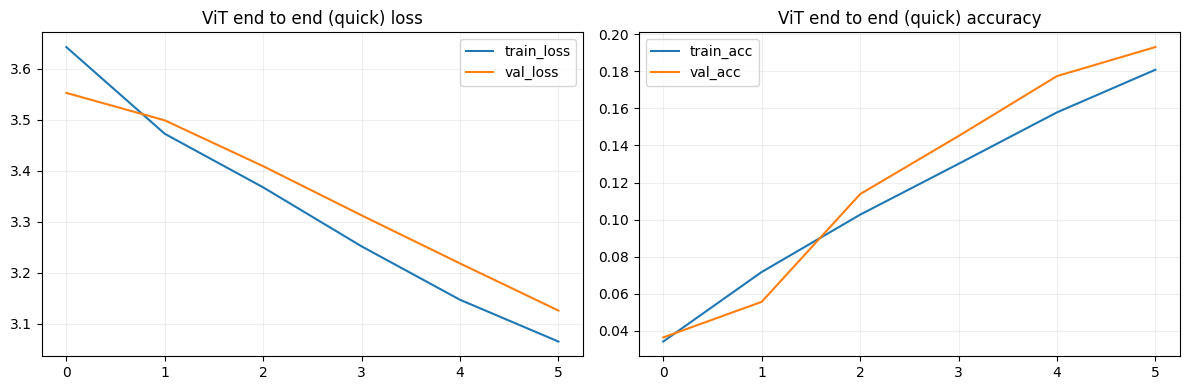

ViT test: {'loss': 3.11786286124566, 'acc': 0.20626895854398383, 'bal_acc': 0.20437838371107328, 'f1_macro': 0.17796741594058357}


In [ ]:
# Fine-tunes end-to-end ViT baseline and evaluates performance.

vit_model_name = "vit_base_patch16_224"
train_loader, val_loader, test_loader, data_cfg, tr_sub, va_sub, te_sub = make_loaders(
    vit_model_name, CFG.img_size, CFG.batch_size
)

w = make_class_weight_tensor()
criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=CFG.label_smoothing)

vit_model = timm.create_model(vit_model_name, pretrained=True, num_classes=num_classes)

vit_model, hist_vit = train_model(
    vit_model, train_loader, val_loader,
    criterion=criterion,
    epochs=CFG.epochs_quick,
    lr=CFG.lr,
    weight_decay=CFG.weight_decay,
    patience=CFG.patience,
    model_name="ViT_end2end"
)

plot_history(hist_vit, "ViT end to end (quick)")

test_m_vit, y_true_vit, y_pred_vit = evaluate(vit_model, test_loader, criterion)
print("ViT test:", test_m_vit)


[MLP_Hybridfeat] ep 01 tr_acc 0.5853 val_acc 0.7341
[MLP_Hybridfeat] ep 02 tr_acc 0.7956 val_acc 0.7952
[MLP_Hybridfeat] ep 03 tr_acc 0.8814 val_acc 0.8306
[MLP_Hybridfeat] ep 04 tr_acc 0.9229 val_acc 0.8347
[MLP_Hybridfeat] ep 05 tr_acc 0.9465 val_acc 0.8438
[MLP_Hybridfeat] ep 06 tr_acc 0.9582 val_acc 0.8478
[MLP_Hybridfeat] ep 07 tr_acc 0.9689 val_acc 0.8332
[MLP_Hybridfeat] ep 08 tr_acc 0.9717 val_acc 0.8372
[MLP_Hybridfeat] ep 09 tr_acc 0.9705 val_acc 0.8589
[MLP_Hybridfeat] ep 10 tr_acc 0.9780 val_acc 0.8488
[MLP_Hybridfeat] ep 11 tr_acc 0.9814 val_acc 0.8483
[MLP_Hybridfeat] ep 12 tr_acc 0.9821 val_acc 0.8569
[MLP_Hybridfeat] ep 13 tr_acc 0.9849 val_acc 0.8544
[MLP_Hybridfeat] ep 14 tr_acc 0.9854 val_acc 0.8524
[MLP_Hybridfeat] ep 15 tr_acc 0.9861 val_acc 0.8524
Early stopping


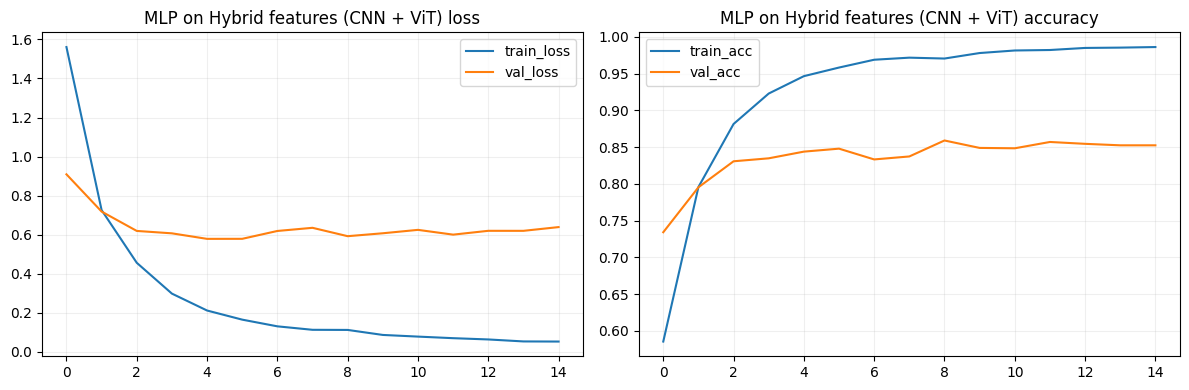

MLP_Hybridfeat: {'test_acc': 0.8488372093023255, 'test_f1_macro': 0.8487431941043533}


In [ ]:
# Trains MLP on hybrid CNN+ViT concatenated features.

mlp_hybrid, hist_mlp_hybrid, res_mlp_hybrid = train_mlp_on_features(
    Xtr_h, ytr, Xva_h, yva, Xte_h, yte,
    hidden=1024, dropout=0.35, lr=8e-4, wd=2e-4,
    epochs=30, patience=6,
    name="MLP_Hybridfeat"
)

plot_history(hist_mlp_hybrid, "MLP on Hybrid features (CNN + ViT)")
print("MLP_Hybridfeat:", res_mlp_hybrid)


In [ ]:
# Compares three models
best_val_mlp_cnn = max([x["val_acc"] for x in hist_mlp_cnn])
best_val_mlp_hyb = max([x["val_acc"] for x in hist_mlp_hybrid])
best_val_vit     = max([x["val_acc"] for x in hist_vit])

df_cmp = pd.DataFrame([
    {"model_type": "DL_on_CNN_features", "best_val_acc": best_val_mlp_cnn, "test_acc": res_mlp_cnn["test_acc"]},
    {"model_type": "Hybrid_DL_on_CNNplusViT_features", "best_val_acc": best_val_mlp_hyb, "test_acc": res_mlp_hybrid["test_acc"]},
    {"model_type": "ViT_end2end", "best_val_acc": best_val_vit, "test_acc": test_m_vit["acc"]},
]).sort_values("best_val_acc", ascending=False)

display(df_cmp)

best_type = df_cmp.iloc[0]["model_type"]
print("Best by validation:", best_type)


model_type  best_val_acc  test_acc
1  Hybrid_DL_on_CNNplusViT_features      0.858948  0.848837
0                DL_on_CNN_features      0.821031  0.812942
2                       ViT_end2end      0.193124  0.206269

Best by validation: Hybrid_DL_on_CNNplusViT_features


In [ ]:
# Tunes best model hyperparameters using Optuna optimization trials.

def objective_best_model(trial: optuna.Trial):
    if best_type in ["DL_on_CNN_features", "Hybrid_DL_on_CNNplusViT_features"]:
        Xtr = Xtr_cnn if best_type == "DL_on_CNN_features" else Xtr_h
        Xva = Xva_cnn if best_type == "DL_on_CNN_features" else Xva_h
        ytr0, yva0 = ytr, yva

        hidden = trial.suggest_categorical("hidden", [256, 512, 768, 1024, 1536])
        dropout = trial.suggest_float("dropout", 0.1, 0.5)
        lr = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
        wd = trial.suggest_float("weight_decay", 1e-6, 5e-3, log=True)

        model, hist, _ = train_mlp_on_features(
            Xtr, ytr0, Xva, yva0, Xva, yva0,
            hidden=hidden, dropout=dropout, lr=lr, wd=wd,
            epochs=18, patience=5,
            name="tune_mlp"
        )
        best_val = max([h["val_acc"] for h in hist])
        return best_val

    else:
        model_name = vit_model_name
        lr = trial.suggest_float("lr", 1e-5, 8e-4, log=True)
        wd = trial.suggest_float("weight_decay", 1e-6, 5e-3, log=True)
        ls = trial.suggest_float("label_smoothing", 0.0, 0.15)

        bs = trial.suggest_categorical("batch_size", [16, 32])
        img_size = trial.suggest_categorical("img_size", [224, 384])

        train_loader, val_loader, _, _, _, _, _ = make_loaders(model_name, img_size, bs)

        w = make_class_weight_tensor()
        criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=ls)

        model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)

        model, hist = train_model(
            model, train_loader, val_loader,
            criterion=criterion,
            epochs=6,
            lr=lr,
            weight_decay=wd,
            patience=3,
            model_name="tune_vit"
        )
        best_val = max([h["Acc"] for h in hist])
        return best_val

study_best = optuna.create_study(direction="maximize")
study_best.optimize(objective_best_model, n_trials=CFG.n_trials_best_model)

print("Best tuned params for best model:", study_best.best_params)
print("Best acc:", study_best.best_value)
best_params = study_best.best_params


[I 2026-01-02 16:14:44,053] A new study created in memory with name: no-name-a3c3a67c-d967-4dd8-a44c-5677d83d5560


[tune_mlp] ep 01 tr_acc 0.5123 val_acc 0.7048
[tune_mlp] ep 02 tr_acc 0.7396 val_acc 0.7715
[tune_mlp] ep 03 tr_acc 0.8250 val_acc 0.8033
[tune_mlp] ep 04 tr_acc 0.8764 val_acc 0.8155
[tune_mlp] ep 05 tr_acc 0.9172 val_acc 0.8407
[tune_mlp] ep 06 tr_acc 0.9373 val_acc 0.8387
[tune_mlp] ep 07 tr_acc 0.9521 val_acc 0.8514
[tune_mlp] ep 08 tr_acc 0.9652 val_acc 0.8498
[tune_mlp] ep 09 tr_acc 0.9682 val_acc 0.8554
[tune_mlp] ep 10 tr_acc 0.9749 val_acc 0.8483
[tune_mlp] ep 11 tr_acc 0.9738 val_acc 0.8549
[tune_mlp] ep 12 tr_acc 0.9779 val_acc 0.8549
[tune_mlp] ep 13 tr_acc 0.9811 val_acc 0.8660
[tune_mlp] ep 14 tr_acc 0.9820 val_acc 0.8559
[tune_mlp] ep 15 tr_acc 0.9837 val_acc 0.8559
[tune_mlp] ep 16 tr_acc 0.9849 val_acc 0.8605
[tune_mlp] ep 17 tr_acc 0.9845 val_acc 0.8498


[I 2026-01-02 16:14:47,977] Trial 0 finished with value: 0.8660262891809909 and parameters: {'hidden': 768, 'dropout': 0.39863429891227764, 'lr': 0.0005634040843851276, 'weight_decay': 1.712385007921509e-05}. Best is trial 0 with value: 0.8660262891809909.


[tune_mlp] ep 18 tr_acc 0.9855 val_acc 0.8595
Early stopping
[tune_mlp] ep 01 tr_acc 0.5280 val_acc 0.7184
[tune_mlp] ep 02 tr_acc 0.7471 val_acc 0.7816
[tune_mlp] ep 03 tr_acc 0.8164 val_acc 0.8008
[tune_mlp] ep 04 tr_acc 0.8576 val_acc 0.8225
[tune_mlp] ep 05 tr_acc 0.8933 val_acc 0.8256
[tune_mlp] ep 06 tr_acc 0.9099 val_acc 0.8443
[tune_mlp] ep 07 tr_acc 0.9221 val_acc 0.8357
[tune_mlp] ep 08 tr_acc 0.9383 val_acc 0.8519
[tune_mlp] ep 09 tr_acc 0.9447 val_acc 0.8438
[tune_mlp] ep 10 tr_acc 0.9519 val_acc 0.8605
[tune_mlp] ep 11 tr_acc 0.9562 val_acc 0.8438
[tune_mlp] ep 12 tr_acc 0.9582 val_acc 0.8549
[tune_mlp] ep 13 tr_acc 0.9604 val_acc 0.8549
[tune_mlp] ep 14 tr_acc 0.9635 val_acc 0.8463
[tune_mlp] ep 15 tr_acc 0.9641 val_acc 0.8645
[tune_mlp] ep 16 tr_acc 0.9688 val_acc 0.8539
[tune_mlp] ep 17 tr_acc 0.9734 val_acc 0.8539
[tune_mlp] ep 18 tr_acc 0.9723 val_acc 0.8630


[I 2026-01-02 16:14:51,575] Trial 1 finished with value: 0.8645096056622852 and parameters: {'hidden': 768, 'dropout': 0.4943897479873811, 'lr': 0.001583739512351247, 'weight_decay': 7.224744748694942e-05}. Best is trial 0 with value: 0.8660262891809909.


[tune_mlp] ep 01 tr_acc 0.5508 val_acc 0.7219
[tune_mlp] ep 02 tr_acc 0.7564 val_acc 0.7735
[tune_mlp] ep 03 tr_acc 0.8243 val_acc 0.7988
[tune_mlp] ep 04 tr_acc 0.8720 val_acc 0.8155
[tune_mlp] ep 05 tr_acc 0.9015 val_acc 0.8296
[tune_mlp] ep 06 tr_acc 0.9221 val_acc 0.8377
[tune_mlp] ep 07 tr_acc 0.9319 val_acc 0.8357
[tune_mlp] ep 08 tr_acc 0.9436 val_acc 0.8493
[tune_mlp] ep 09 tr_acc 0.9486 val_acc 0.8488
[tune_mlp] ep 10 tr_acc 0.9539 val_acc 0.8332
[tune_mlp] ep 11 tr_acc 0.9554 val_acc 0.8448
[tune_mlp] ep 12 tr_acc 0.9634 val_acc 0.8559
[tune_mlp] ep 13 tr_acc 0.9627 val_acc 0.8433
[tune_mlp] ep 14 tr_acc 0.9657 val_acc 0.8544
[tune_mlp] ep 15 tr_acc 0.9673 val_acc 0.8498
[tune_mlp] ep 16 tr_acc 0.9682 val_acc 0.8579
[tune_mlp] ep 17 tr_acc 0.9731 val_acc 0.8589


[I 2026-01-02 16:14:55,391] Trial 2 finished with value: 0.858948432760364 and parameters: {'hidden': 512, 'dropout': 0.40479989244698056, 'lr': 0.002289578555065888, 'weight_decay': 1.28844220134104e-06}. Best is trial 0 with value: 0.8660262891809909.


[tune_mlp] ep 18 tr_acc 0.9745 val_acc 0.8509
[tune_mlp] ep 01 tr_acc 0.5706 val_acc 0.7204
[tune_mlp] ep 02 tr_acc 0.7809 val_acc 0.7882
[tune_mlp] ep 03 tr_acc 0.8647 val_acc 0.8185
[tune_mlp] ep 04 tr_acc 0.9102 val_acc 0.8352
[tune_mlp] ep 05 tr_acc 0.9411 val_acc 0.8392
[tune_mlp] ep 06 tr_acc 0.9557 val_acc 0.8493
[tune_mlp] ep 07 tr_acc 0.9626 val_acc 0.8579
[tune_mlp] ep 08 tr_acc 0.9668 val_acc 0.8569
[tune_mlp] ep 09 tr_acc 0.9748 val_acc 0.8539
[tune_mlp] ep 10 tr_acc 0.9780 val_acc 0.8559
[tune_mlp] ep 11 tr_acc 0.9758 val_acc 0.8600
[tune_mlp] ep 12 tr_acc 0.9784 val_acc 0.8539
[tune_mlp] ep 13 tr_acc 0.9787 val_acc 0.8610
[tune_mlp] ep 14 tr_acc 0.9824 val_acc 0.8579
[tune_mlp] ep 15 tr_acc 0.9856 val_acc 0.8569
[tune_mlp] ep 16 tr_acc 0.9842 val_acc 0.8701
[tune_mlp] ep 17 tr_acc 0.9852 val_acc 0.8589


[I 2026-01-02 16:14:59,040] Trial 3 finished with value: 0.8700707785642062 and parameters: {'hidden': 1024, 'dropout': 0.3917757956026068, 'lr': 0.0007646145968360398, 'weight_decay': 1.1803451080025874e-05}. Best is trial 3 with value: 0.8700707785642062.


[tune_mlp] ep 18 tr_acc 0.9860 val_acc 0.8564
[tune_mlp] ep 01 tr_acc 0.5804 val_acc 0.7290
[tune_mlp] ep 02 tr_acc 0.7879 val_acc 0.7912
[tune_mlp] ep 03 tr_acc 0.8689 val_acc 0.8069
[tune_mlp] ep 04 tr_acc 0.9106 val_acc 0.8266
[tune_mlp] ep 05 tr_acc 0.9345 val_acc 0.8357
[tune_mlp] ep 06 tr_acc 0.9540 val_acc 0.8311
[tune_mlp] ep 07 tr_acc 0.9677 val_acc 0.8443
[tune_mlp] ep 08 tr_acc 0.9709 val_acc 0.8362
[tune_mlp] ep 09 tr_acc 0.9707 val_acc 0.8347
[tune_mlp] ep 10 tr_acc 0.9780 val_acc 0.8478
[tune_mlp] ep 11 tr_acc 0.9787 val_acc 0.8443
[tune_mlp] ep 12 tr_acc 0.9804 val_acc 0.8382
[tune_mlp] ep 13 tr_acc 0.9837 val_acc 0.8458
[tune_mlp] ep 14 tr_acc 0.9836 val_acc 0.8407


[I 2026-01-02 16:15:02,263] Trial 4 finished with value: 0.8478260869565217 and parameters: {'hidden': 256, 'dropout': 0.15035239955590285, 'lr': 0.002863721171398487, 'weight_decay': 2.949184647010954e-06}. Best is trial 3 with value: 0.8700707785642062.


[tune_mlp] ep 15 tr_acc 0.9831 val_acc 0.8337
Early stopping
[tune_mlp] ep 01 tr_acc 0.6323 val_acc 0.7563
[tune_mlp] ep 02 tr_acc 0.8391 val_acc 0.8028
[tune_mlp] ep 03 tr_acc 0.9150 val_acc 0.8266
[tune_mlp] ep 04 tr_acc 0.9466 val_acc 0.8377
[tune_mlp] ep 05 tr_acc 0.9690 val_acc 0.8504
[tune_mlp] ep 06 tr_acc 0.9732 val_acc 0.8433
[tune_mlp] ep 07 tr_acc 0.9728 val_acc 0.8392
[tune_mlp] ep 08 tr_acc 0.9787 val_acc 0.8549
[tune_mlp] ep 09 tr_acc 0.9834 val_acc 0.8549
[tune_mlp] ep 10 tr_acc 0.9829 val_acc 0.8463
[tune_mlp] ep 11 tr_acc 0.9872 val_acc 0.8519
[tune_mlp] ep 12 tr_acc 0.9871 val_acc 0.8579
[tune_mlp] ep 13 tr_acc 0.9852 val_acc 0.8574
[tune_mlp] ep 14 tr_acc 0.9862 val_acc 0.8514
[tune_mlp] ep 15 tr_acc 0.9858 val_acc 0.8514
[tune_mlp] ep 16 tr_acc 0.9876 val_acc 0.8529


[I 2026-01-02 16:15:05,644] Trial 5 finished with value: 0.8579373104145601 and parameters: {'hidden': 1024, 'dropout': 0.1793342619358135, 'lr': 0.001222252613989478, 'weight_decay': 0.0005220948715614718}. Best is trial 3 with value: 0.8700707785642062.


[tune_mlp] ep 17 tr_acc 0.9870 val_acc 0.8514
Early stopping
[tune_mlp] ep 01 tr_acc 0.5924 val_acc 0.7295
[tune_mlp] ep 02 tr_acc 0.8110 val_acc 0.7993
[tune_mlp] ep 03 tr_acc 0.8958 val_acc 0.8266
[tune_mlp] ep 04 tr_acc 0.9379 val_acc 0.8367
[tune_mlp] ep 05 tr_acc 0.9629 val_acc 0.8443
[tune_mlp] ep 06 tr_acc 0.9718 val_acc 0.8504
[tune_mlp] ep 07 tr_acc 0.9771 val_acc 0.8529
[tune_mlp] ep 08 tr_acc 0.9785 val_acc 0.8458
[tune_mlp] ep 09 tr_acc 0.9832 val_acc 0.8605
[tune_mlp] ep 10 tr_acc 0.9858 val_acc 0.8514
[tune_mlp] ep 11 tr_acc 0.9855 val_acc 0.8529
[tune_mlp] ep 12 tr_acc 0.9854 val_acc 0.8539
[tune_mlp] ep 13 tr_acc 0.9860 val_acc 0.8650
[tune_mlp] ep 14 tr_acc 0.9883 val_acc 0.8595
[tune_mlp] ep 15 tr_acc 0.9887 val_acc 0.8721
[tune_mlp] ep 16 tr_acc 0.9885 val_acc 0.8665
[tune_mlp] ep 17 tr_acc 0.9878 val_acc 0.8665


[I 2026-01-02 16:15:09,784] Trial 6 finished with value: 0.872093023255814 and parameters: {'hidden': 1536, 'dropout': 0.29832440723161124, 'lr': 0.00040572094700813547, 'weight_decay': 5.372570108649731e-05}. Best is trial 6 with value: 0.872093023255814.


[tune_mlp] ep 18 tr_acc 0.9883 val_acc 0.8584
[tune_mlp] ep 01 tr_acc 0.5908 val_acc 0.7447
[tune_mlp] ep 02 tr_acc 0.8007 val_acc 0.7988
[tune_mlp] ep 03 tr_acc 0.8753 val_acc 0.8190
[tune_mlp] ep 04 tr_acc 0.9150 val_acc 0.8241
[tune_mlp] ep 05 tr_acc 0.9393 val_acc 0.8205
[tune_mlp] ep 06 tr_acc 0.9492 val_acc 0.8433
[tune_mlp] ep 07 tr_acc 0.9620 val_acc 0.8387
[tune_mlp] ep 08 tr_acc 0.9622 val_acc 0.8605
[tune_mlp] ep 09 tr_acc 0.9686 val_acc 0.8504
[tune_mlp] ep 10 tr_acc 0.9683 val_acc 0.8463
[tune_mlp] ep 11 tr_acc 0.9724 val_acc 0.8554
[tune_mlp] ep 12 tr_acc 0.9788 val_acc 0.8483


[I 2026-01-02 16:15:12,371] Trial 7 finished with value: 0.8604651162790697 and parameters: {'hidden': 1024, 'dropout': 0.36185390578127374, 'lr': 0.0017078172073899686, 'weight_decay': 8.818359607489907e-05}. Best is trial 6 with value: 0.872093023255814.


[tune_mlp] ep 13 tr_acc 0.9789 val_acc 0.8519
Early stopping
[tune_mlp] ep 01 tr_acc 0.3500 val_acc 0.6016
[tune_mlp] ep 02 tr_acc 0.6016 val_acc 0.6825
[tune_mlp] ep 03 tr_acc 0.6836 val_acc 0.7240
[tune_mlp] ep 04 tr_acc 0.7401 val_acc 0.7482
[tune_mlp] ep 05 tr_acc 0.7815 val_acc 0.7735
[tune_mlp] ep 06 tr_acc 0.8184 val_acc 0.7897
[tune_mlp] ep 07 tr_acc 0.8433 val_acc 0.8043
[tune_mlp] ep 08 tr_acc 0.8665 val_acc 0.8124
[tune_mlp] ep 09 tr_acc 0.8893 val_acc 0.8195
[tune_mlp] ep 10 tr_acc 0.9077 val_acc 0.8337
[tune_mlp] ep 11 tr_acc 0.9215 val_acc 0.8377
[tune_mlp] ep 12 tr_acc 0.9346 val_acc 0.8433
[tune_mlp] ep 13 tr_acc 0.9423 val_acc 0.8519
[tune_mlp] ep 14 tr_acc 0.9540 val_acc 0.8569
[tune_mlp] ep 15 tr_acc 0.9617 val_acc 0.8584
[tune_mlp] ep 16 tr_acc 0.9661 val_acc 0.8564
[tune_mlp] ep 17 tr_acc 0.9718 val_acc 0.8625


[I 2026-01-02 16:15:16,190] Trial 8 finished with value: 0.8624873609706775 and parameters: {'hidden': 1024, 'dropout': 0.4187391204071419, 'lr': 0.00011670069653100813, 'weight_decay': 2.865497767489146e-06}. Best is trial 6 with value: 0.872093023255814.


[tune_mlp] ep 18 tr_acc 0.9752 val_acc 0.8600
[tune_mlp] ep 01 tr_acc 0.6054 val_acc 0.7371
[tune_mlp] ep 02 tr_acc 0.8118 val_acc 0.7867
[tune_mlp] ep 03 tr_acc 0.8872 val_acc 0.8236
[tune_mlp] ep 04 tr_acc 0.9196 val_acc 0.8291
[tune_mlp] ep 05 tr_acc 0.9412 val_acc 0.8453
[tune_mlp] ep 06 tr_acc 0.9533 val_acc 0.8428
[tune_mlp] ep 07 tr_acc 0.9637 val_acc 0.8423
[tune_mlp] ep 08 tr_acc 0.9673 val_acc 0.8488
[tune_mlp] ep 09 tr_acc 0.9724 val_acc 0.8448
[tune_mlp] ep 10 tr_acc 0.9732 val_acc 0.8493
[tune_mlp] ep 11 tr_acc 0.9741 val_acc 0.8549
[tune_mlp] ep 12 tr_acc 0.9753 val_acc 0.8463
[tune_mlp] ep 13 tr_acc 0.9783 val_acc 0.8534
[tune_mlp] ep 14 tr_acc 0.9813 val_acc 0.8544
[tune_mlp] ep 15 tr_acc 0.9798 val_acc 0.8524
[tune_mlp] ep 16 tr_acc 0.9837 val_acc 0.8620
[tune_mlp] ep 17 tr_acc 0.9846 val_acc 0.8529


[I 2026-01-02 16:15:20,172] Trial 9 finished with value: 0.8619817997977756 and parameters: {'hidden': 1536, 'dropout': 0.40591684045421894, 'lr': 0.001119133677732972, 'weight_decay': 5.80740090350087e-06}. Best is trial 6 with value: 0.872093023255814.


[tune_mlp] ep 18 tr_acc 0.9867 val_acc 0.8554
[tune_mlp] ep 01 tr_acc 0.5386 val_acc 0.6997
[tune_mlp] ep 02 tr_acc 0.7695 val_acc 0.7781
[tune_mlp] ep 03 tr_acc 0.8577 val_acc 0.8049
[tune_mlp] ep 04 tr_acc 0.9094 val_acc 0.8316
[tune_mlp] ep 05 tr_acc 0.9443 val_acc 0.8473
[tune_mlp] ep 06 tr_acc 0.9639 val_acc 0.8544
[tune_mlp] ep 07 tr_acc 0.9733 val_acc 0.8504
[tune_mlp] ep 08 tr_acc 0.9818 val_acc 0.8584
[tune_mlp] ep 09 tr_acc 0.9847 val_acc 0.8635
[tune_mlp] ep 10 tr_acc 0.9862 val_acc 0.8655
[tune_mlp] ep 11 tr_acc 0.9887 val_acc 0.8625
[tune_mlp] ep 12 tr_acc 0.9890 val_acc 0.8670
[tune_mlp] ep 13 tr_acc 0.9896 val_acc 0.8600
[tune_mlp] ep 14 tr_acc 0.9887 val_acc 0.8595
[tune_mlp] ep 15 tr_acc 0.9897 val_acc 0.8660
[tune_mlp] ep 16 tr_acc 0.9902 val_acc 0.8686
[tune_mlp] ep 17 tr_acc 0.9902 val_acc 0.8650


[I 2026-01-02 16:15:24,199] Trial 10 finished with value: 0.8685540950455005 and parameters: {'hidden': 1536, 'dropout': 0.24675894667761816, 'lr': 0.0001985712532368649, 'weight_decay': 0.00471711072759449}. Best is trial 6 with value: 0.872093023255814.


[tune_mlp] ep 18 tr_acc 0.9908 val_acc 0.8655
[tune_mlp] ep 01 tr_acc 0.5875 val_acc 0.7361
[tune_mlp] ep 02 tr_acc 0.8196 val_acc 0.8008
[tune_mlp] ep 03 tr_acc 0.9013 val_acc 0.8352
[tune_mlp] ep 04 tr_acc 0.9438 val_acc 0.8473
[tune_mlp] ep 05 tr_acc 0.9652 val_acc 0.8519
[tune_mlp] ep 06 tr_acc 0.9702 val_acc 0.8498
[tune_mlp] ep 07 tr_acc 0.9787 val_acc 0.8574
[tune_mlp] ep 08 tr_acc 0.9801 val_acc 0.8519
[tune_mlp] ep 09 tr_acc 0.9823 val_acc 0.8625
[tune_mlp] ep 10 tr_acc 0.9852 val_acc 0.8645
[tune_mlp] ep 11 tr_acc 0.9882 val_acc 0.8630
[tune_mlp] ep 12 tr_acc 0.9869 val_acc 0.8584
[tune_mlp] ep 13 tr_acc 0.9872 val_acc 0.8650
[tune_mlp] ep 14 tr_acc 0.9874 val_acc 0.8645
[tune_mlp] ep 15 tr_acc 0.9900 val_acc 0.8554
[tune_mlp] ep 16 tr_acc 0.9893 val_acc 0.8670
[tune_mlp] ep 17 tr_acc 0.9897 val_acc 0.8574


[I 2026-01-02 16:15:27,997] Trial 11 finished with value: 0.8685540950455005 and parameters: {'hidden': 1536, 'dropout': 0.2887604714230534, 'lr': 0.0004593603768078045, 'weight_decay': 2.8363526845322423e-05}. Best is trial 6 with value: 0.872093023255814.


[tune_mlp] ep 18 tr_acc 0.9902 val_acc 0.8686
Best tuned params for best model: {'hidden': 1536, 'dropout': 0.29832440723161124, 'lr': 0.00040572094700813547, 'weight_decay': 5.372570108649731e-05}
Best acc: 0.872093023255814


[FINAL_best_MLP] ep 01 tr_acc 0.5871 val_acc 0.7467
[FINAL_best_MLP] ep 02 tr_acc 0.8101 val_acc 0.7973
[FINAL_best_MLP] ep 03 tr_acc 0.8915 val_acc 0.8413
[FINAL_best_MLP] ep 04 tr_acc 0.9363 val_acc 0.8433
[FINAL_best_MLP] ep 05 tr_acc 0.9633 val_acc 0.8544
[FINAL_best_MLP] ep 06 tr_acc 0.9734 val_acc 0.8595
[FINAL_best_MLP] ep 07 tr_acc 0.9780 val_acc 0.8620
[FINAL_best_MLP] ep 08 tr_acc 0.9837 val_acc 0.8554
[FINAL_best_MLP] ep 09 tr_acc 0.9845 val_acc 0.8544
[FINAL_best_MLP] ep 10 tr_acc 0.9849 val_acc 0.8605
[FINAL_best_MLP] ep 11 tr_acc 0.9864 val_acc 0.8660
[FINAL_best_MLP] ep 12 tr_acc 0.9865 val_acc 0.8655
[FINAL_best_MLP] ep 13 tr_acc 0.9878 val_acc 0.8605
[FINAL_best_MLP] ep 14 tr_acc 0.9880 val_acc 0.8711
[FINAL_best_MLP] ep 15 tr_acc 0.9893 val_acc 0.8660
[FINAL_best_MLP] ep 16 tr_acc 0.9883 val_acc 0.8589
[FINAL_best_MLP] ep 17 tr_acc 0.9854 val_acc 0.8564
[FINAL_best_MLP] ep 18 tr_acc 0.9856 val_acc 0.8655
[FINAL_best_MLP] ep 19 tr_acc 0.9888 val_acc 0.8696
[FINAL_best_

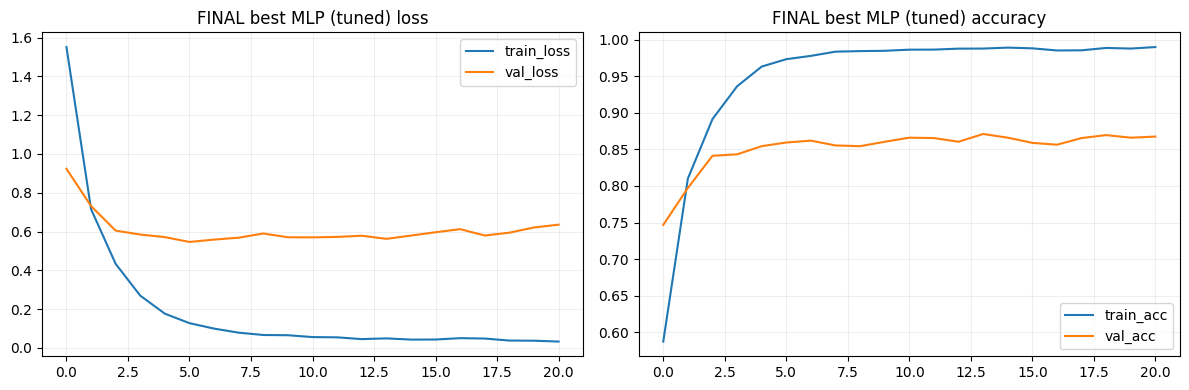

FINAL best MLP: {'test_acc': 0.8584428715874621, 'test_f1_macro': 0.8575020915037699}


In [ ]:
# Retrains tuned best model fully

final_results = {}

if best_type in ["DL_on_CNN_features", "Hybrid_DL_on_CNNplusViT_features"]:
    Xtr = Xtr_cnn if best_type == "DL_on_CNN_features" else Xtr_h
    Xva = Xva_cnn if best_type == "DL_on_CNN_features" else Xva_h
    Xte = Xte_cnn if best_type == "DL_on_CNN_features" else Xte_h

    final_mlp, hist_final_mlp, res_final_mlp = train_mlp_on_features(
        Xtr, ytr, Xva, yva, Xte, yte,
        hidden=best_params["hidden"],
        dropout=best_params["dropout"],
        lr=best_params["lr"],
        wd=best_params["weight_decay"],
        epochs=35, patience=7,
        name="FINAL_best_MLP"
    )
    plot_history(hist_final_mlp, "FINAL best MLP (tuned)")
    final_results["best_model_test_acc"] = res_final_mlp["test_acc"]
    print("FINAL best MLP:", res_final_mlp)

else:
    img_size = best_params["img_size"]
    bs = best_params["batch_size"]
    lr = best_params["lr"]
    wd = best_params["weight_decay"]
    ls = best_params["label_smoothing"]

    train_loader, val_loader, test_loader, data_cfg, _, _, _ = make_loaders(vit_model_name, img_size, bs)
    w = make_class_weight_tensor()
    criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=ls)

    vit_final = timm.create_model(vit_model_name, pretrained=True, num_classes=num_classes)
    vit_final, hist_final_vit = train_model(
        vit_final, train_loader, val_loader,
        criterion=criterion,
        epochs=CFG.epochs_full,
        lr=lr,
        weight_decay=wd,
        patience=CFG.patience,
        model_name="FINAL_best_ViT"
    )
    plot_history(hist_final_vit, "FINAL best ViT (tuned)")

    test_m, yt, yp = evaluate(vit_final, test_loader, criterion)
    print("FINAL best ViT test:", test_m)
    final_results["best_model_test_acc"] = test_m["acc"]


In [ ]:
# Tunes CustomViT architecture and training hyperparameters via Optuna.

import optuna
import torch.nn as nn
import timm

class CustomViT(nn.Module):
    def __init__(
        self,
        backbone_name: str,
        img_size: int,
        num_classes: int,
        head_hidden: int,
        dropout: float,
        unfreeze_blocks: int
    ):
        super().__init__()

        # make backbone match the input image size
        # dynamic_img_size=True makes it tolerant in many timm ViT variants
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=True,
            num_classes=0,
            img_size=img_size,
            dynamic_img_size=True
        )
        d = self.backbone.num_features

        # freeze all
        for p in self.backbone.parameters():
            p.requires_grad = False

        # unfreeze last N blocks (if available)
        if hasattr(self.backbone, "blocks"):
            n_blocks = len(self.backbone.blocks)
            k = max(1, min(int(unfreeze_blocks), n_blocks))
            for blk in self.backbone.blocks[-k:]:
                for p in blk.parameters():
                    p.requires_grad = True

        # unfreeze norm (if available)
        if hasattr(self.backbone, "norm"):
            for p in self.backbone.norm.parameters():
                p.requires_grad = True

        # custom classifier head
        self.head = nn.Sequential(
            nn.Linear(d, head_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(head_hidden, num_classes)
        )

    def forward(self, x):
        f = self.backbone(x)
        return self.head(f)

def objective_custom_vit(trial: optuna.Trial):
    lr = trial.suggest_float("lr", 1e-5, 6e-4, log=True)
    wd = trial.suggest_float("weight_decay", 1e-6, 5e-3, log=True)
    ls = trial.suggest_float("label_smoothing", 0.0, 0.12)

    head_hidden = trial.suggest_categorical("head_hidden", [256, 512, 768, 1024])
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    unfreeze_blocks = trial.suggest_int("unfreeze_blocks", 2, 10)

    img_size = trial.suggest_categorical("img_size", [224, 384])
    bs = trial.suggest_categorical("batch_size", [16, 32])

    backbone = vit_backbone  # e.g. "vit_base_patch16_224"

    # loaders use your transforms with chosen img_size
    train_loader, val_loader, _, _, _, _, _ = make_loaders(backbone, img_size, bs)

    w = make_class_weight_tensor()
    criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=ls)

    # IMPORTANT: pass img_size into CustomViT
    model = CustomViT(
        backbone_name=backbone,
        img_size=img_size,
        num_classes=num_classes,
        head_hidden=head_hidden,
        dropout=dropout,
        unfreeze_blocks=unfreeze_blocks
    )

    model, hist = train_model(
        model, train_loader, val_loader,
        criterion=criterion,
        epochs=7,
        lr=lr,
        weight_decay=wd,
        patience=3,
        model_name="tune_custom_vit"
    )
    return max(h["val_acc"] for h in hist)

study_custom = optuna.create_study(direction="maximize")
study_custom.optimize(objective_custom_vit, n_trials=CFG.n_trials_custom_vit)

print("Custom ViT best params:", study_custom.best_params)
print("Custom ViT best val acc:", study_custom.best_value)

custom_params = study_custom.best_params


[I 2026-01-02 16:18:31,535] A new study created in memory with name: no-name-3182de42-1b5f-4fcc-a569-8d1649cc91c4


[tune_custom_vit] ep 01 tr_acc 0.3523 val_acc 0.4191 val_f1 0.3824
[tune_custom_vit] ep 02 tr_acc 0.5412 val_acc 0.6572 val_f1 0.6592
[tune_custom_vit] ep 03 tr_acc 0.6273 val_acc 0.7412 val_f1 0.7445
[tune_custom_vit] ep 04 tr_acc 0.7113 val_acc 0.7816 val_f1 0.7845
[tune_custom_vit] ep 05 tr_acc 0.7715 val_acc 0.8069 val_f1 0.8090
[tune_custom_vit] ep 06 tr_acc 0.8256 val_acc 0.8261 val_f1 0.8269
[tune_custom_vit] ep 07 tr_acc 0.8624 val_acc 0.8372 val_f1 0.8382


[I 2026-01-02 16:25:32,630] Trial 0 finished with value: 0.8372093023255814 and parameters: {'lr': 0.0002002997924063685, 'weight_decay': 1.8525620706922997e-05, 'label_smoothing': 0.09815422979425656, 'head_hidden': 256, 'dropout': 0.29238835112688655, 'unfreeze_blocks': 9, 'img_size': 224, 'batch_size': 32}. Best is trial 0 with value: 0.8372093023255814.


[tune_custom_vit] ep 01 tr_acc 0.5056 val_acc 0.5536 val_f1 0.5299
[tune_custom_vit] ep 02 tr_acc 0.7089 val_acc 0.7705 val_f1 0.7670
[tune_custom_vit] ep 03 tr_acc 0.7832 val_acc 0.8271 val_f1 0.8265
[tune_custom_vit] ep 04 tr_acc 0.8324 val_acc 0.8524 val_f1 0.8526
[tune_custom_vit] ep 05 tr_acc 0.8651 val_acc 0.8655 val_f1 0.8659
[tune_custom_vit] ep 06 tr_acc 0.8968 val_acc 0.8761 val_f1 0.8760
[tune_custom_vit] ep 07 tr_acc 0.9062 val_acc 0.8852 val_f1 0.8850


[I 2026-01-02 16:32:36,969] Trial 1 finished with value: 0.8852376137512639 and parameters: {'lr': 2.5192242136336452e-05, 'weight_decay': 3.2832415923700702e-06, 'label_smoothing': 0.041655708706374424, 'head_hidden': 768, 'dropout': 0.2654168228082301, 'unfreeze_blocks': 9, 'img_size': 224, 'batch_size': 16}. Best is trial 1 with value: 0.8852376137512639.


[tune_custom_vit] ep 01 tr_acc 0.4604 val_acc 0.3564 val_f1 0.3274
[tune_custom_vit] ep 02 tr_acc 0.6632 val_acc 0.6780 val_f1 0.6675
[tune_custom_vit] ep 03 tr_acc 0.7420 val_acc 0.7942 val_f1 0.7924
[tune_custom_vit] ep 04 tr_acc 0.8022 val_acc 0.8311 val_f1 0.8304
[tune_custom_vit] ep 05 tr_acc 0.8462 val_acc 0.8534 val_f1 0.8529
[tune_custom_vit] ep 06 tr_acc 0.8827 val_acc 0.8665 val_f1 0.8661
[tune_custom_vit] ep 07 tr_acc 0.8967 val_acc 0.8741 val_f1 0.8737


[I 2026-01-02 16:39:29,578] Trial 2 finished with value: 0.8741152679474217 and parameters: {'lr': 7.158085987860281e-05, 'weight_decay': 0.0017236642660953595, 'label_smoothing': 0.031816600285941354, 'head_hidden': 256, 'dropout': 0.26285925594105125, 'unfreeze_blocks': 10, 'img_size': 224, 'batch_size': 32}. Best is trial 1 with value: 0.8852376137512639.


[tune_custom_vit] ep 01 tr_acc 0.4835 val_acc 0.3418 val_f1 0.3062
[tune_custom_vit] ep 02 tr_acc 0.6972 val_acc 0.6830 val_f1 0.6798
[tune_custom_vit] ep 03 tr_acc 0.7814 val_acc 0.7917 val_f1 0.7911
[tune_custom_vit] ep 04 tr_acc 0.8315 val_acc 0.8332 val_f1 0.8335
[tune_custom_vit] ep 05 tr_acc 0.8664 val_acc 0.8569 val_f1 0.8570
[tune_custom_vit] ep 06 tr_acc 0.8957 val_acc 0.8645 val_f1 0.8644
[tune_custom_vit] ep 07 tr_acc 0.9096 val_acc 0.8711 val_f1 0.8710


[I 2026-01-02 16:46:25,963] Trial 3 finished with value: 0.8710819009100101 and parameters: {'lr': 5.816726667128483e-05, 'weight_decay': 4.679736391474795e-05, 'label_smoothing': 0.11036554941670182, 'head_hidden': 512, 'dropout': 0.42294306585700614, 'unfreeze_blocks': 7, 'img_size': 224, 'batch_size': 32}. Best is trial 1 with value: 0.8852376137512639.


[tune_custom_vit] ep 01 tr_acc 0.5003 val_acc 0.5460 val_f1 0.5305
[tune_custom_vit] ep 02 tr_acc 0.7058 val_acc 0.7700 val_f1 0.7699
[tune_custom_vit] ep 03 tr_acc 0.7853 val_acc 0.8296 val_f1 0.8294
[tune_custom_vit] ep 04 tr_acc 0.8378 val_acc 0.8544 val_f1 0.8541
[tune_custom_vit] ep 05 tr_acc 0.8842 val_acc 0.8696 val_f1 0.8692
[tune_custom_vit] ep 06 tr_acc 0.9076 val_acc 0.8777 val_f1 0.8772
[tune_custom_vit] ep 07 tr_acc 0.9169 val_acc 0.8822 val_f1 0.8816


[I 2026-01-02 16:57:25,658] Trial 4 finished with value: 0.8822042467138523 and parameters: {'lr': 3.056602342668045e-05, 'weight_decay': 0.000672660186981807, 'label_smoothing': 0.03761176007719073, 'head_hidden': 1024, 'dropout': 0.10370318530179552, 'unfreeze_blocks': 9, 'img_size': 384, 'batch_size': 16}. Best is trial 1 with value: 0.8852376137512639.


[tune_custom_vit] ep 01 tr_acc 0.4453 val_acc 0.4302 val_f1 0.4043
[tune_custom_vit] ep 02 tr_acc 0.6774 val_acc 0.7336 val_f1 0.7305
[tune_custom_vit] ep 03 tr_acc 0.7516 val_acc 0.7983 val_f1 0.7979
[tune_custom_vit] ep 04 tr_acc 0.8030 val_acc 0.8357 val_f1 0.8358
[tune_custom_vit] ep 05 tr_acc 0.8375 val_acc 0.8529 val_f1 0.8532
[tune_custom_vit] ep 06 tr_acc 0.8620 val_acc 0.8579 val_f1 0.8578
[tune_custom_vit] ep 07 tr_acc 0.8809 val_acc 0.8620 val_f1 0.8616


[I 2026-01-02 17:08:25,724] Trial 5 finished with value: 0.8619817997977756 and parameters: {'lr': 1.9307196779154718e-05, 'weight_decay': 3.560707714198436e-05, 'label_smoothing': 0.017609640527960043, 'head_hidden': 256, 'dropout': 0.25774849326379573, 'unfreeze_blocks': 10, 'img_size': 384, 'batch_size': 16}. Best is trial 1 with value: 0.8852376137512639.


[tune_custom_vit] ep 01 tr_acc 0.0419 val_acc 0.0303 val_f1 0.0017
[tune_custom_vit] ep 02 tr_acc 0.0686 val_acc 0.0576 val_f1 0.0189
[tune_custom_vit] ep 03 tr_acc 0.1026 val_acc 0.1244 val_f1 0.0706
[tune_custom_vit] ep 04 tr_acc 0.1465 val_acc 0.1759 val_f1 0.1251
[tune_custom_vit] ep 05 tr_acc 0.1955 val_acc 0.2260 val_f1 0.1822
[tune_custom_vit] ep 06 tr_acc 0.2378 val_acc 0.2639 val_f1 0.2332
[tune_custom_vit] ep 07 tr_acc 0.2611 val_acc 0.2902 val_f1 0.2643


[I 2026-01-02 17:15:27,477] Trial 6 finished with value: 0.2901921132457027 and parameters: {'lr': 0.0005760060564001579, 'weight_decay': 6.086446532398687e-05, 'label_smoothing': 0.02887762049160757, 'head_hidden': 256, 'dropout': 0.42308235522919657, 'unfreeze_blocks': 6, 'img_size': 224, 'batch_size': 16}. Best is trial 1 with value: 0.8852376137512639.


[tune_custom_vit] ep 01 tr_acc 0.4880 val_acc 0.5228 val_f1 0.5088
[tune_custom_vit] ep 02 tr_acc 0.6822 val_acc 0.7533 val_f1 0.7498
[tune_custom_vit] ep 03 tr_acc 0.7478 val_acc 0.8023 val_f1 0.8004
[tune_custom_vit] ep 04 tr_acc 0.7988 val_acc 0.8205 val_f1 0.8193
[tune_custom_vit] ep 05 tr_acc 0.8281 val_acc 0.8387 val_f1 0.8378
[tune_custom_vit] ep 06 tr_acc 0.8490 val_acc 0.8493 val_f1 0.8488
[tune_custom_vit] ep 07 tr_acc 0.8613 val_acc 0.8529 val_f1 0.8527


[I 2026-01-02 17:22:28,232] Trial 7 finished with value: 0.852881698685541 and parameters: {'lr': 4.2065498690771896e-05, 'weight_decay': 1.8467991706458796e-06, 'label_smoothing': 0.1122498898605988, 'head_hidden': 256, 'dropout': 0.3960218700025141, 'unfreeze_blocks': 3, 'img_size': 224, 'batch_size': 16}. Best is trial 1 with value: 0.8852376137512639.


[tune_custom_vit] ep 01 tr_acc 0.4227 val_acc 0.1957 val_f1 0.1869
[tune_custom_vit] ep 02 tr_acc 0.6535 val_acc 0.4909 val_f1 0.4695
[tune_custom_vit] ep 03 tr_acc 0.7254 val_acc 0.6385 val_f1 0.6285
[tune_custom_vit] ep 04 tr_acc 0.7684 val_acc 0.7194 val_f1 0.7166
[tune_custom_vit] ep 05 tr_acc 0.7939 val_acc 0.7654 val_f1 0.7649
[tune_custom_vit] ep 06 tr_acc 0.8097 val_acc 0.7947 val_f1 0.7945
[tune_custom_vit] ep 07 tr_acc 0.8254 val_acc 0.8094 val_f1 0.8093


[I 2026-01-02 17:29:22,631] Trial 8 finished with value: 0.8094034378159757 and parameters: {'lr': 1.1375073862215452e-05, 'weight_decay': 0.001978554323392421, 'label_smoothing': 0.1025080601451506, 'head_hidden': 768, 'dropout': 0.22506106255681996, 'unfreeze_blocks': 6, 'img_size': 224, 'batch_size': 32}. Best is trial 1 with value: 0.8852376137512639.


[tune_custom_vit] ep 01 tr_acc 0.4997 val_acc 0.3903 val_f1 0.3601
[tune_custom_vit] ep 02 tr_acc 0.6787 val_acc 0.6967 val_f1 0.6916
[tune_custom_vit] ep 03 tr_acc 0.7611 val_acc 0.7806 val_f1 0.7803
[tune_custom_vit] ep 04 tr_acc 0.8139 val_acc 0.8134 val_f1 0.8138
[tune_custom_vit] ep 05 tr_acc 0.8472 val_acc 0.8438 val_f1 0.8441
[tune_custom_vit] ep 06 tr_acc 0.8856 val_acc 0.8579 val_f1 0.8583
[tune_custom_vit] ep 07 tr_acc 0.8956 val_acc 0.8655 val_f1 0.8657


[I 2026-01-02 17:40:13,255] Trial 9 finished with value: 0.865520728008089 and parameters: {'lr': 0.00011298497871743314, 'weight_decay': 0.0007826905408568357, 'label_smoothing': 0.022891983944129245, 'head_hidden': 768, 'dropout': 0.4529294159837026, 'unfreeze_blocks': 4, 'img_size': 384, 'batch_size': 32}. Best is trial 1 with value: 0.8852376137512639.


[tune_custom_vit] ep 01 tr_acc 0.4508 val_acc 0.4039 val_f1 0.3743
[tune_custom_vit] ep 02 tr_acc 0.6761 val_acc 0.7042 val_f1 0.6962
[tune_custom_vit] ep 03 tr_acc 0.7448 val_acc 0.7770 val_f1 0.7751
[tune_custom_vit] ep 04 tr_acc 0.7982 val_acc 0.8145 val_f1 0.8133
[tune_custom_vit] ep 05 tr_acc 0.8285 val_acc 0.8311 val_f1 0.8304
[tune_custom_vit] ep 06 tr_acc 0.8506 val_acc 0.8407 val_f1 0.8400
[tune_custom_vit] ep 07 tr_acc 0.8601 val_acc 0.8483 val_f1 0.8476


[I 2026-01-02 17:51:13,815] Trial 10 finished with value: 0.8483316481294236 and parameters: {'lr': 1.1208473304734308e-05, 'weight_decay': 1.0124875188359197e-06, 'label_smoothing': 0.06797478521161202, 'head_hidden': 768, 'dropout': 0.17244204621816592, 'unfreeze_blocks': 8, 'img_size': 384, 'batch_size': 16}. Best is trial 1 with value: 0.8852376137512639.


[tune_custom_vit] ep 01 tr_acc 0.5240 val_acc 0.5693 val_f1 0.5607
[tune_custom_vit] ep 02 tr_acc 0.7195 val_acc 0.7846 val_f1 0.7822
[tune_custom_vit] ep 03 tr_acc 0.7903 val_acc 0.8266 val_f1 0.8254
[tune_custom_vit] ep 04 tr_acc 0.8418 val_acc 0.8478 val_f1 0.8471
[tune_custom_vit] ep 05 tr_acc 0.8804 val_acc 0.8620 val_f1 0.8613
[tune_custom_vit] ep 06 tr_acc 0.9046 val_acc 0.8741 val_f1 0.8738
[tune_custom_vit] ep 07 tr_acc 0.9140 val_acc 0.8822 val_f1 0.8821


[I 2026-01-02 18:02:12,752] Trial 11 finished with value: 0.8822042467138523 and parameters: {'lr': 2.812942134159856e-05, 'weight_decay': 0.00030055937269264204, 'label_smoothing': 0.05622914281404978, 'head_hidden': 1024, 'dropout': 0.12546541939197198, 'unfreeze_blocks': 8, 'img_size': 384, 'batch_size': 16}. Best is trial 1 with value: 0.8852376137512639.


[tune_custom_vit] ep 01 tr_acc 0.4720 val_acc 0.4904 val_f1 0.4783
[tune_custom_vit] ep 02 tr_acc 0.6935 val_acc 0.7508 val_f1 0.7491
[tune_custom_vit] ep 03 tr_acc 0.7639 val_acc 0.8099 val_f1 0.8094
[tune_custom_vit] ep 04 tr_acc 0.8152 val_acc 0.8337 val_f1 0.8334
[tune_custom_vit] ep 05 tr_acc 0.8549 val_acc 0.8514 val_f1 0.8518
[tune_custom_vit] ep 06 tr_acc 0.8824 val_acc 0.8579 val_f1 0.8580
[tune_custom_vit] ep 07 tr_acc 0.8934 val_acc 0.8615 val_f1 0.8615


[I 2026-01-02 18:13:13,268] Trial 12 finished with value: 0.8614762386248737 and parameters: {'lr': 2.3820936642150896e-05, 'weight_decay': 8.39379192029485e-06, 'label_smoothing': 0.05347196774282976, 'head_hidden': 1024, 'dropout': 0.34713290971349137, 'unfreeze_blocks': 8, 'img_size': 384, 'batch_size': 16}. Best is trial 1 with value: 0.8852376137512639.


[tune_custom_vit] ep 01 tr_acc 0.5379 val_acc 0.5693 val_f1 0.5566
[tune_custom_vit] ep 02 tr_acc 0.7280 val_acc 0.7765 val_f1 0.7747
[tune_custom_vit] ep 03 tr_acc 0.7934 val_acc 0.8276 val_f1 0.8271
[tune_custom_vit] ep 04 tr_acc 0.8460 val_acc 0.8413 val_f1 0.8408
[tune_custom_vit] ep 05 tr_acc 0.8725 val_acc 0.8534 val_f1 0.8529
[tune_custom_vit] ep 06 tr_acc 0.8942 val_acc 0.8605 val_f1 0.8601
[tune_custom_vit] ep 07 tr_acc 0.9069 val_acc 0.8645 val_f1 0.8641


[I 2026-01-02 18:24:11,574] Trial 13 finished with value: 0.8645096056622852 and parameters: {'lr': 3.569762245874811e-05, 'weight_decay': 0.00022661049991017267, 'label_smoothing': 0.0001436358992790987, 'head_hidden': 1024, 'dropout': 0.10035461424803538, 'unfreeze_blocks': 5, 'img_size': 384, 'batch_size': 16}. Best is trial 1 with value: 0.8852376137512639.


[tune_custom_vit] ep 01 tr_acc 0.3721 val_acc 0.5915 val_f1 0.5706
[tune_custom_vit] ep 02 tr_acc 0.5394 val_acc 0.7401 val_f1 0.7367
[tune_custom_vit] ep 03 tr_acc 0.6288 val_acc 0.7826 val_f1 0.7814
[tune_custom_vit] ep 04 tr_acc 0.7049 val_acc 0.8043 val_f1 0.8034
[tune_custom_vit] ep 05 tr_acc 0.7815 val_acc 0.8241 val_f1 0.8238
[tune_custom_vit] ep 06 tr_acc 0.8389 val_acc 0.8418 val_f1 0.8416
[tune_custom_vit] ep 07 tr_acc 0.8677 val_acc 0.8539 val_f1 0.8533


[I 2026-01-02 18:31:18,072] Trial 14 finished with value: 0.8538928210313448 and parameters: {'lr': 0.00014077275285623092, 'weight_decay': 6.14542995669087e-06, 'label_smoothing': 0.07410151629658634, 'head_hidden': 512, 'dropout': 0.20366901979134117, 'unfreeze_blocks': 10, 'img_size': 224, 'batch_size': 16}. Best is trial 1 with value: 0.8852376137512639.


Custom ViT best params: {'lr': 2.5192242136336452e-05, 'weight_decay': 3.2832415923700702e-06, 'label_smoothing': 0.041655708706374424, 'head_hidden': 768, 'dropout': 0.2654168228082301, 'unfreeze_blocks': 9, 'img_size': 224, 'batch_size': 16}
Custom ViT best val acc: 0.8852376137512639


[FINAL_CustomViT] ep 01 tr_acc 0.5183 val_acc 0.5733 val_f1 0.5685
[FINAL_CustomViT] ep 02 tr_acc 0.7127 val_acc 0.7846 val_f1 0.7836
[FINAL_CustomViT] ep 03 tr_acc 0.7788 val_acc 0.8286 val_f1 0.8289
[FINAL_CustomViT] ep 04 tr_acc 0.8214 val_acc 0.8579 val_f1 0.8585
[FINAL_CustomViT] ep 05 tr_acc 0.8441 val_acc 0.8696 val_f1 0.8698
[FINAL_CustomViT] ep 06 tr_acc 0.8743 val_acc 0.8822 val_f1 0.8823
[FINAL_CustomViT] ep 07 tr_acc 0.8900 val_acc 0.8908 val_f1 0.8905
[FINAL_CustomViT] ep 08 tr_acc 0.9074 val_acc 0.8893 val_f1 0.8892
[FINAL_CustomViT] ep 09 tr_acc 0.9171 val_acc 0.8918 val_f1 0.8914
[FINAL_CustomViT] ep 10 tr_acc 0.9332 val_acc 0.8953 val_f1 0.8949
[FINAL_CustomViT] ep 11 tr_acc 0.9353 val_acc 0.8918 val_f1 0.8914
[FINAL_CustomViT] ep 12 tr_acc 0.9436 val_acc 0.8928 val_f1 0.8923
[FINAL_CustomViT] ep 13 tr_acc 0.9456 val_acc 0.8938 val_f1 0.8933
[FINAL_CustomViT] ep 14 tr_acc 0.9456 val_acc 0.8913 val_f1 0.8907


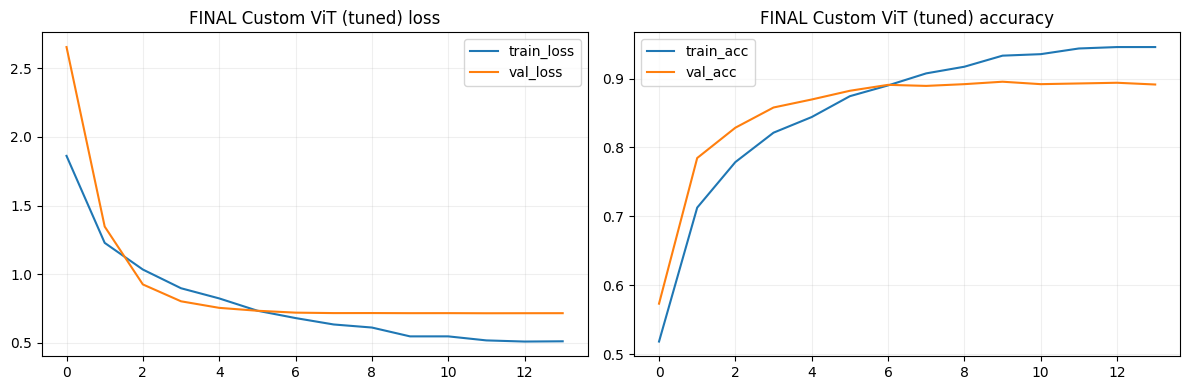

Custom ViT: {'loss': 0.5291343796998262, 'acc': 0.9377170138888888, 'bal_acc': 0.9374094807333918, 'f1_macro': 0.9374362024611652}
                             precision    recall  f1-score   support

     agkistrodon-contortrix     0.9528    0.9603    0.9565       252
     agkistrodon-piscivorus     0.9496    0.9199    0.9345       287
        coluber-constrictor     0.9194    0.9366    0.9279       268
             crotalus-atrox     0.9466    0.9268    0.9366       287
          crotalus-horridus     0.9524    0.9562    0.9543       251
             crotalus-ruber     0.9289    0.9592    0.9438       245
        crotalus-scutulatus     0.9158    0.9542    0.9346       262
           crotalus-viridis     0.9641    0.9202    0.9416       263
        diadophis-punctatus     0.9627    0.9810    0.9718       263
           haldea-striatula     0.9294    0.9080    0.9186       261
      heterodon-platirhinos     0.9355    0.9457    0.9405       276
   lampropeltis-californiae     0.9770  

In [ ]:
# Evaluate Matrics

backbone = vit_backbone
img_size = custom_params["img_size"]
bs = custom_params["batch_size"]

train_loader, val_loader, test_loader, data_cfg, _, _, _ = make_loaders(backbone, img_size, bs)

w = make_class_weight_tensor()
criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=custom_params["label_smoothing"])

custom_vit_final = CustomViT(
    backbone_name=backbone,
    img_size=img_size,
    num_classes=num_classes,
    head_hidden=custom_params["head_hidden"],
    dropout=custom_params["dropout"],
    unfreeze_blocks=custom_params["unfreeze_blocks"]
)

custom_vit_final, hist_custom_final = train_model(
    custom_vit_final,
    train_loader, val_loader,
    criterion=criterion,
    epochs=CFG.epochs_full,
    lr=custom_params["lr"],
    weight_decay=custom_params["weight_decay"],
    patience=CFG.patience,
    model_name="FINAL_CustomViT"
)

plot_history(hist_custom_final, "FINAL Custom ViT (tuned)")

train_m, y_true, y_pred = evaluate(custom_vit_final, train_loader, criterion)
print("Custom ViT:", train_m)
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

@torch.no_grad()
def tta_eval(model, loader):
    model.eval()
    all_y, all_p = [], []
    for x, y in loader:
        x = x.to(device)
        with autocast(device_type="cuda" if device=="cuda" else "cpu"):
            logits1 = model(x)
            logits2 = model(torch.flip(x, dims=[3]))
            logits = (logits1 + logits2) / 2.0
        preds = logits.argmax(1).cpu().numpy()
        all_p.append(preds)
        all_y.append(y.numpy())
    y_true = np.concatenate(all_y)
    y_pred = np.concatenate(all_p)
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average="macro")

tta_acc, tta_f1 = tta_eval(custom_vit_final, train_loader)
print("Custom ViT Test acc:", tta_acc)
print("Custom ViT macro F1:", tta_f1)

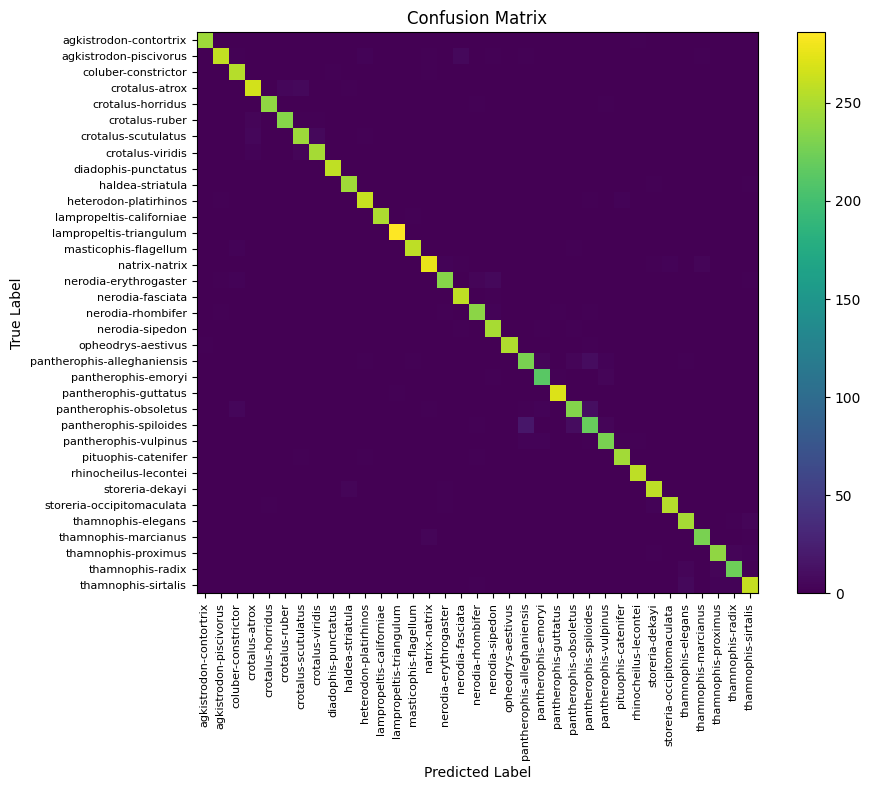

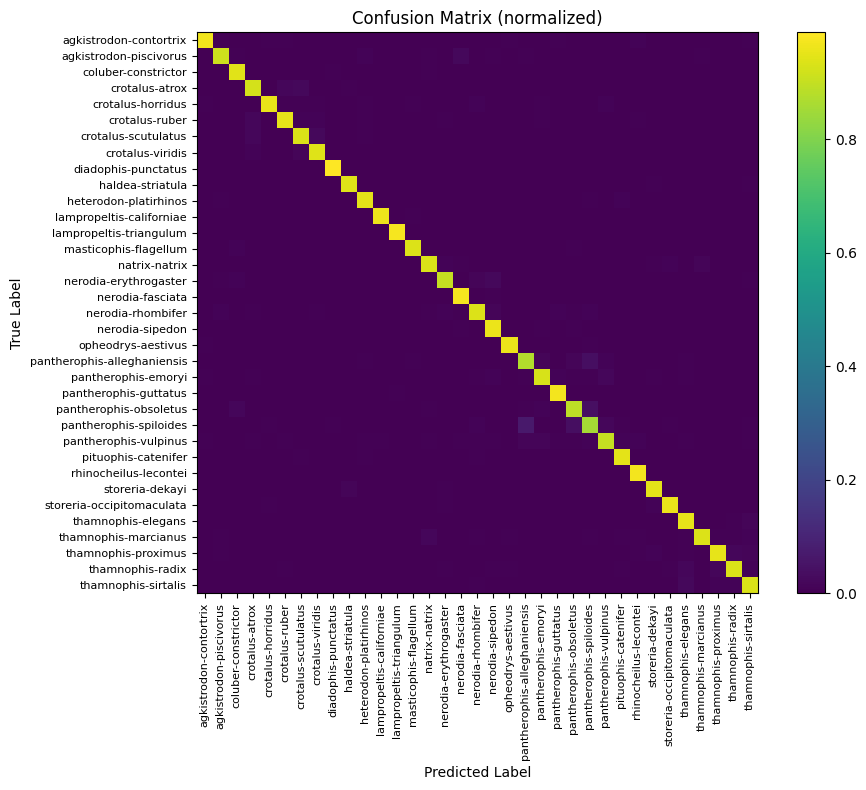

Confusion matrices generated


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix", normalize=False, max_classes_to_show=None):
    cm = cm.astype(np.float32)

    if normalize:
        cm = cm / (cm.sum(axis=1, keepdims=True) + 1e-8)

    if max_classes_to_show is not None and cm.shape[0] > max_classes_to_show:
        cm = cm[:max_classes_to_show, :max_classes_to_show]
        class_names = class_names[:max_classes_to_show]

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90, fontsize=8)
    plt.yticks(tick_marks, class_names, fontsize=8)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

@torch.no_grad()
def get_preds(model, loader):
    model.eval()
    all_y, all_p = [], []
    for x, y in loader:
        x = x.to(device)
        with autocast(device_type="cuda" if device=="cuda" else "cpu"):
            logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        all_p.append(preds)
        all_y.append(y.numpy())
    y_true = np.concatenate(all_y)
    y_pred = np.concatenate(all_p)
    return y_true, y_pred

@torch.no_grad()
def tta_eval_preds(model, loader):
    model.eval()
    all_y, all_p = [], []
    for x, y in loader:
        x = x.to(device)
        with autocast(device_type="cuda" if device=="cuda" else "cpu"):
            logits1 = model(x)
            logits2 = model(torch.flip(x, dims=[3]))
            logits = (logits1 + logits2) / 2.0
        preds = logits.argmax(1).cpu().numpy()
        all_p.append(preds)
        all_y.append(y.numpy())
    y_true = np.concatenate(all_y)
    y_pred = np.concatenate(all_p)
    return y_true, y_pred

ytr_true, ytr_pred = get_preds(custom_vit_final, train_loader)
cm_train = confusion_matrix(ytr_true, ytr_pred, labels=list(range(num_classes)))
plot_confusion_matrix(cm_train, classes, title="Confusion Matrix", normalize=False)
plot_confusion_matrix(cm_train, classes, title="Confusion Matrix (normalized)", normalize=True)

print("Confusion matrices generated")


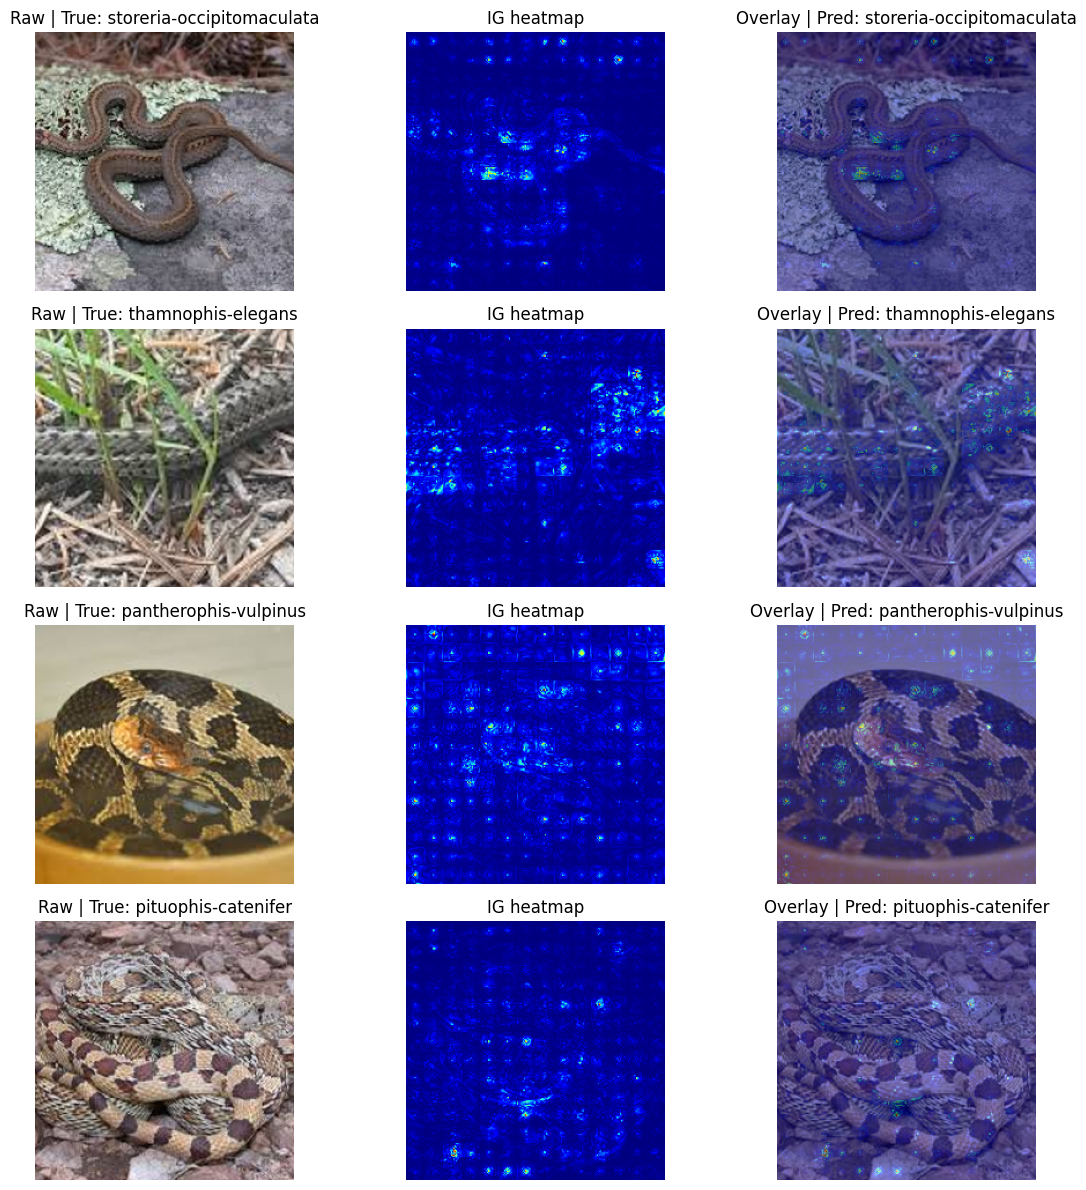

In [ ]:
# Generates Integrated Gradients heatmaps to explain CustomViT predictions.

custom_vit_final.eval()
ig = IntegratedGradients(custom_vit_final)

samples_to_show = 4
idxs = np.random.choice(range(len(test_loader.dataset)), size=min(samples_to_show, len(test_loader.dataset)), replace=False)

plt.figure(figsize=(12, 3*samples_to_show))

for i, idx in enumerate(idxs, start=1):
    x, y = test_loader.dataset[idx]
    x_in = x.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = custom_vit_final(x_in).argmax(1).item()

    attr = ig.attribute(x_in, target=pred, n_steps=16)
    attr = attr.abs().mean(dim=1).squeeze().detach().cpu().numpy()
    attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)

    img = denorm_tensor(x, data_cfg["mean"], data_cfg["std"]).permute(1,2,0).numpy()
    heat = cv2.applyColorMap((attr*255).astype(np.uint8), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB) / 255.0
    overlay = (0.55*img + 0.45*heat).clip(0,1)

    plt.subplot(samples_to_show, 3, (i-1)*3 + 1)
    plt.imshow(img)
    plt.title(f"Raw | True: {classes[y]}")
    plt.axis("off")

    plt.subplot(samples_to_show, 3, (i-1)*3 + 2)
    plt.imshow(attr, cmap="jet")
    plt.title("IG heatmap")
    plt.axis("off")

    plt.subplot(samples_to_show, 3, (i-1)*3 + 3)
    plt.imshow(overlay)
    plt.title(f"Overlay | Pred: {classes[pred]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# XAI (LIME Setup)

!pip -q install lime scikit-image

import numpy as np
import matplotlib.pyplot as plt

from lime import lime_image
from skimage.segmentation import slic, mark_boundaries
from PIL import Image

lime_eval_tfm, _ = build_transforms(backbone, img_size, is_train=False)

def get_raw_test_sample(i: int):
    subset = test_loader.dataset
    img_path, y = subset.dataset.samples[subset.indices[i]]
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img, dtype=np.uint8)
    return img_np, int(y), img_path

@torch.no_grad()
def lime_predict_proba(images: List[np.ndarray]) -> np.ndarray:
    batch = []
    for img_np in images:
        pil = Image.fromarray(img_np.astype(np.uint8))
        x = lime_eval_tfm(pil)
        batch.append(x)
    batch = torch.stack(batch, dim=0).to(device)

    custom_vit_final.eval()
    with autocast(device_type="cuda" if device=="cuda" else "cpu"):
        logits = custom_vit_final(batch)
        probs = torch.softmax(logits, dim=1)

    return probs.detach().cpu().numpy()

lime_explainer = lime_image.LimeImageExplainer()

def lime_segmenter(x):
    return slic(x, n_segments=120, compactness=10, sigma=1)


  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

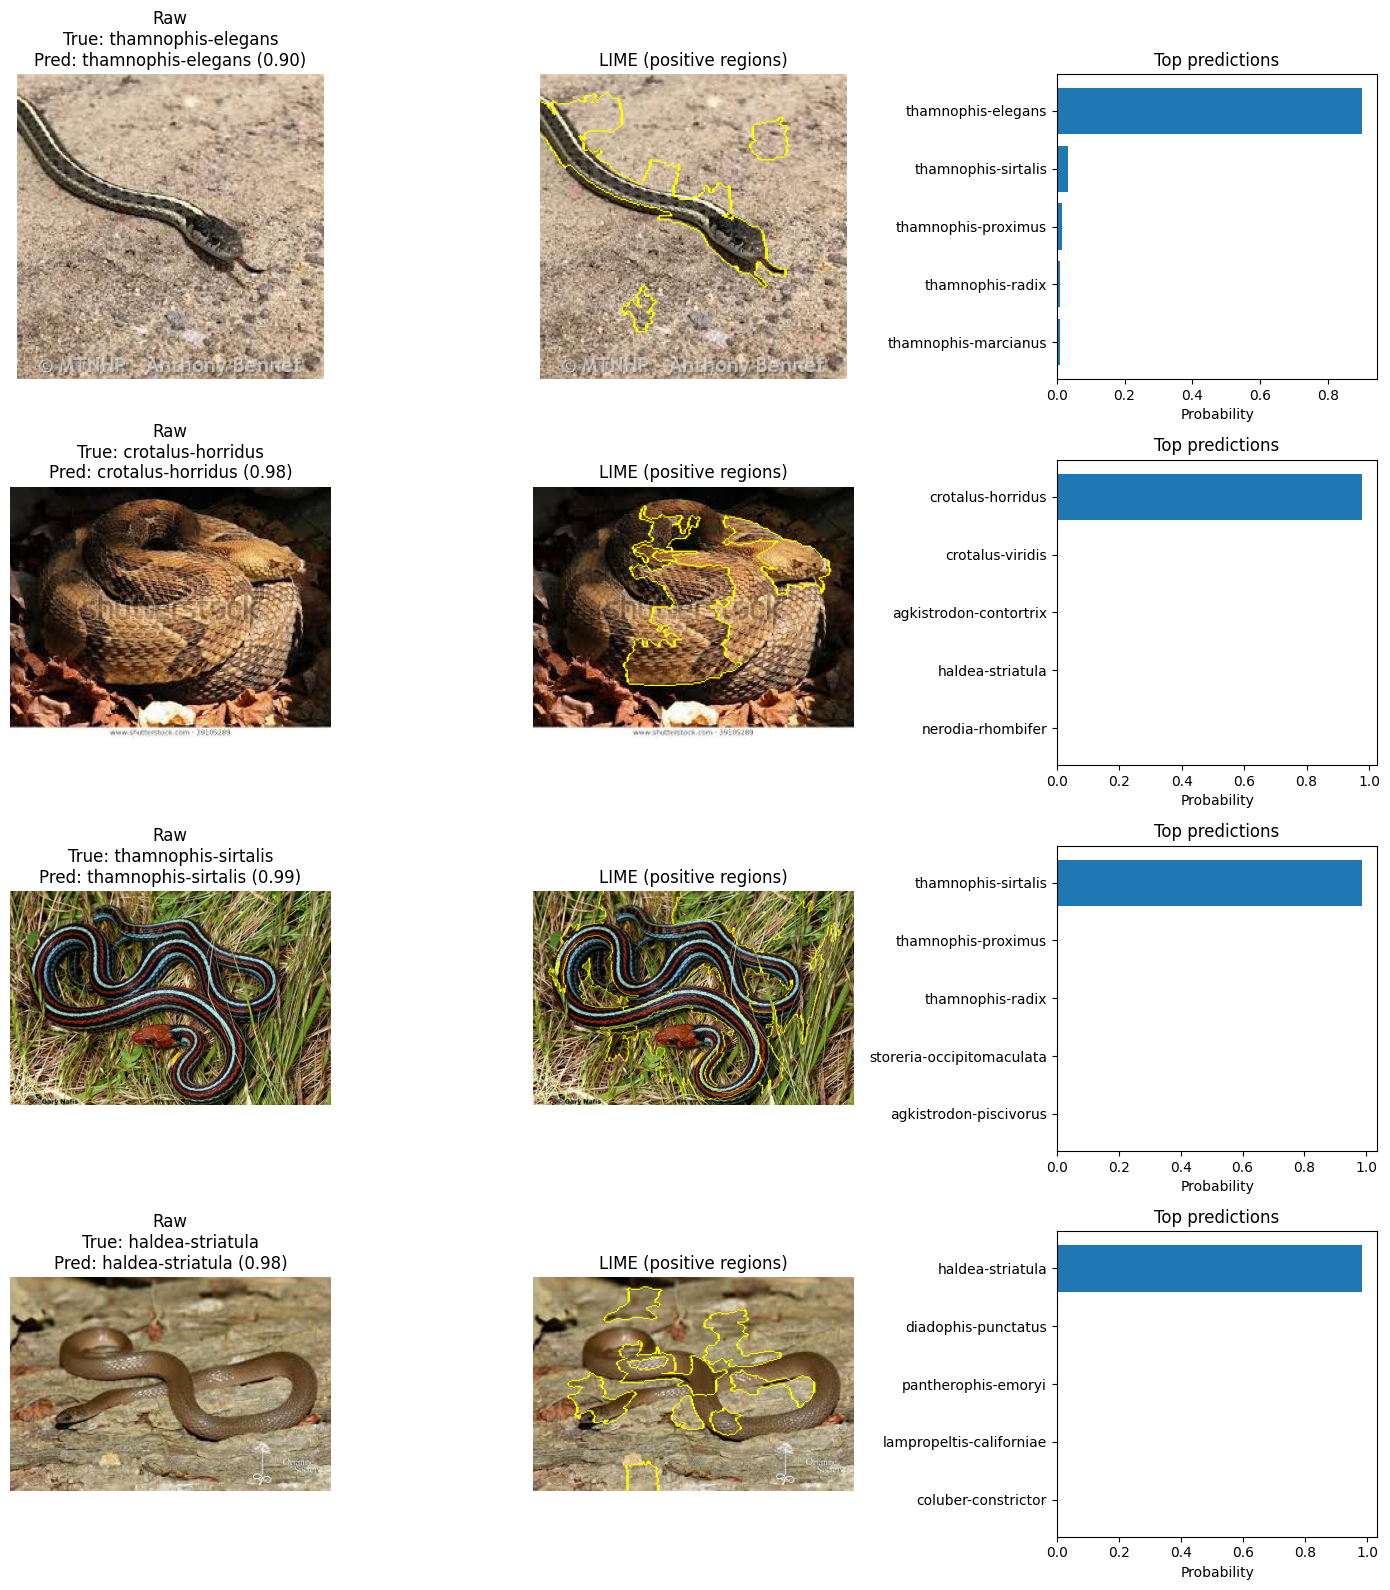

In [ ]:
# Run LIME explanations on images

samples_to_show = 4
test_n = len(test_loader.dataset)
idxs = np.random.choice(range(test_n), size=min(samples_to_show, test_n), replace=False)

plt.figure(figsize=(14, 4 * len(idxs)))

for row_i, idx in enumerate(idxs, start=1):
    img_np, y_true, img_path = get_raw_test_sample(idx)

    probs = lime_predict_proba([img_np])[0]
    y_pred = int(np.argmax(probs))
    conf = float(probs[y_pred])

    explanation = lime_explainer.explain_instance(
        image=img_np,
        classifier_fn=lime_predict_proba,
        top_labels=3,
        hide_color=0,
        num_samples=700,
        segmentation_fn=lime_segmenter
    )

    temp, mask = explanation.get_image_and_mask(
        label=y_pred,
        positive_only=True,
        num_features=12,
        hide_rest=False
    )

    plt.subplot(len(idxs), 3, (row_i-1)*3 + 1)
    plt.imshow(img_np)
    plt.title(f"Raw\nTrue: {classes[y_true]}\nPred: {classes[y_pred]} ({conf:.2f})")
    plt.axis("off")

    plt.subplot(len(idxs), 3, (row_i-1)*3 + 2)
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title("LIME (positive regions)")
    plt.axis("off")

    topk = 5
    top_idx = np.argsort(probs)[::-1][:topk]
    top_probs = probs[top_idx]
    top_names = [classes[i] for i in top_idx]

    plt.subplot(len(idxs), 3, (row_i-1)*3 + 3)
    plt.barh(top_names[::-1], top_probs[::-1])
    plt.title("Top predictions")
    plt.xlabel("Probability")
    plt.tight_layout()

plt.show()


In [ ]:
import os, json, time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

save_root = "/content/drive/MyDrive/ml-project2/snake_research_runs"
run_name = time.strftime("run_%Y%m%d_%H%M%S")
save_dir = os.path.join(save_root, run_name)
os.makedirs(save_dir, exist_ok=True)

print("Saving to:", save_dir)

def save_json(obj, path):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def save_df(df, path):
    df.to_csv(path, index=False)

def save_text(text, path):
    with open(path, "w") as f:
        f.write(text)

def save_fig(name):
    plt.savefig(os.path.join(save_dir, f"{name}.png"), dpi=200, bbox_inches="tight")

def safe_torch_save(state_dict, name):
    torch.save(state_dict, os.path.join(save_dir, name))

np.save(os.path.join(save_dir, "train_idx.npy"), np.array(train_idx))
np.save(os.path.join(save_dir, "val_idx.npy"), np.array(val_idx))
np.save(os.path.join(save_dir, "test_idx.npy"), np.array(test_idx))

label_map = {"class_to_idx": base_ds.class_to_idx, "idx_to_class": {v:k for k,v in base_ds.class_to_idx.items()}}
save_json(label_map, os.path.join(save_dir, "label_map.json"))

if "hist_mlp_cnn" in globals():
    save_df(pd.DataFrame(hist_mlp_cnn), os.path.join(save_dir, "hist_mlp_cnn.csv"))
if "hist_mlp_hybrid" in globals():
    save_df(pd.DataFrame(hist_mlp_hybrid), os.path.join(save_dir, "hist_mlp_hybrid.csv"))
if "hist_vit" in globals():
    save_df(pd.DataFrame(hist_vit), os.path.join(save_dir, "hist_vit.csv"))
if "hist_final_mlp" in globals():
    save_df(pd.DataFrame(hist_final_mlp), os.path.join(save_dir, "hist_final_mlp.csv"))
if "hist_final_vit" in globals():
    save_df(pd.DataFrame(hist_final_vit), os.path.join(save_dir, "hist_final_vit.csv"))
if "hist_custom_final" in globals():
    save_df(pd.DataFrame(hist_custom_final), os.path.join(save_dir, "hist_custom_vit.csv"))
if "hist_custom_final" not in globals() and "hist_custom_final" in locals():
    save_df(pd.DataFrame(hist_custom_final), os.path.join(save_dir, "hist_custom_vit.csv"))

# Feature MLPs
if "mlp_cnn" in globals():
    safe_torch_save(mlp_cnn.state_dict(), "mlp_cnnfeat.pth")
if "mlp_hybrid" in globals():
    safe_torch_save(mlp_hybrid.state_dict(), "mlp_hybridfeat.pth")

# ViT baseline
if "vit_model" in globals():
    safe_torch_save(vit_model.state_dict(), "vit_end2end_quick.pth")
if "vit_final" in globals():
    safe_torch_save(vit_final.state_dict(), "vit_final_tuned.pth")

# Custom ViT final
if "custom_vit_final" in globals():
    safe_torch_save(custom_vit_final.state_dict(), "custom_vit_final.pth")

artifacts = {
    "classes": classes,
    "cfg": CFG.__dict__,
    "best_model_type": best_type if "best_type" in globals() else None,
    "best_model_tuned_params": best_params if "best_params" in globals() else None,
    "custom_vit_params": custom_params if "custom_params" in globals() else None,
}

if "test_m" in globals():
    artifacts["custom_vit_test"] = {
        "acc": float(test_m.get("acc", -1)),
        "macro_f1": float(test_m.get("f1_macro", -1)),
        "loss": float(test_m.get("loss", -1))
    }
if "tta_acc" in globals():
    artifacts["custom_vit_test_tta"] = {"acc": float(tta_acc), "macro_f1": float(tta_f1)}

save_json(artifacts, os.path.join(save_dir, "run_artifacts.json"))

if "yt_true" in globals() and "yt_pred" in globals():
    rep = classification_report(yt_true, yt_pred, target_names=classes, digits=4)
    save_text(rep, os.path.join(save_dir, "classification_report_test.txt"))

    cm = confusion_matrix(yt_true, yt_pred)
    np.save(os.path.join(save_dir, "confusion_matrix_test.npy"), cm)

    plt.figure(figsize=(10,8))
    plt.imshow(cm)
    plt.title("Confusion Matrix (Test)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.tight_layout()
    save_fig("confusion_matrix_test")
    plt.close()

if "Xtr_cnn" in globals():
    np.save(os.path.join(save_dir, "Xtr_cnn.npy"), Xtr_cnn)
    np.save(os.path.join(save_dir, "Xva_cnn.npy"), Xva_cnn)
    np.save(os.path.join(save_dir, "Xte_cnn.npy"), Xte_cnn)
if "Xtr_h" in globals():
    np.save(os.path.join(save_dir, "Xtr_hybrid.npy"), Xtr_h)
    np.save(os.path.join(save_dir, "Xva_hybrid.npy"), Xva_h)
    np.save(os.path.join(save_dir, "Xte_hybrid.npy"), Xte_h)

print("Saved everything into:", save_dir)


Saving to: /content/drive/MyDrive/ml-project2/snake_research_runs/run_20260102_191935
Saved everything into: /content/drive/MyDrive/ml-project2/snake_research_runs/run_20260102_191935
